In [4]:
import os
from scipy.io import loadmat
from scipy.stats import ranksums
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import h5py
from learned_tuning.learned_tuning import calculate_learned_tuning_PBE_subsets, calculate_place_field_fidelity_of_learned_tuning

%matplotlib widget


data_dir = r'/home/kouroshmaboudi/Documents/Learned_tuning_Python/Datasets'
sessions = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

included_session_IDX = [x for x in range(17) if x not in (12, 13)]
# included_session_IDX = np.arange(6, 11)
# included_session_IDX = [2]


sessions = [sessions[i] for i in included_session_IDX]

number_of_sessions = len(sessions)


epochs = np.empty((number_of_sessions,), dtype=object)
epoch_durations = np.empty((number_of_sessions,), dtype=object)


time_bins_centers = np.empty((number_of_sessions,), dtype=object)
time_bin_brain_state_2D_array = np.empty((number_of_sessions,), dtype=object)

spatial_tunings_maze = np.empty((number_of_sessions,), dtype=object)
stable_above_1Hz_PF_unit_index = np.empty((number_of_sessions,), dtype=object)

learned_tunings = np.empty((number_of_sessions,), dtype=object)
learned_tunings_place_field_corr = np.empty((number_of_sessions,), dtype=object)
learned_tunings_place_field_corr_unit_id_shuffle = np.empty((number_of_sessions,), dtype=object)

for session_idx, session_name in enumerate(sessions):

    print(session_name)

    session_dataset_path = os.path.join(data_dir, session_name)
    session_number = included_session_IDX[session_idx]

    #--------------------------------------------------------------------------------------------
    # Load epochs[session_idx] information

    filename = f'{session_name}.fileInfo_for_python.mat'
    file_path = os.path.join(session_dataset_path, filename)

    mat_file = loadmat(file_path)
    session_info = mat_file["fileInfo"]

    epochs[session_idx] = session_info["behavior"][0][0][0][0]["time"]
    epoch_durations[session_idx] = epochs[session_idx][:, 1] - epochs[session_idx][:, 0]

    epoch_names = ['PRE', 'MAZE', 'POST']
   
    
    #---------------------------------------------------------------------------------------------
    # Brain state detection results

    if 0<=session_number<=4 or 6<=session_number<=10:
        filename = f'{session_name}.brainStateDetection_HMMtheta_EMG_SWS_SchmidtTrigger.mat'
        file_path = os.path.join(session_dataset_path, filename)

        mat_file = loadmat(file_path)
        brainStates_bouts_label = mat_file['brainState']['bouts'][0][0][:, :-1]
        bouts_start_end = brainStates_bouts_label[:, :-1]
        bout_duration = bouts_start_end[:, 1] - bouts_start_end[:, 0] 
        bout_labels = brainStates_bouts_label[:, -1].astype(int)

        brainStates_names = []
        for i in range(4):
            brainStates_names.append(mat_file['brainState']['names'][0][0][i][0][0])
    
    else: # Miyawaki dataset

        filename = f'{session_name}.fileInfo_for_python.mat'
        file_path = os.path.join(session_dataset_path, filename)

        mat_file = loadmat(file_path)
        brainStates_bouts_label = mat_file['fileInfo']['brainStates'].item()

        bouts_start_end = brainStates_bouts_label[:, :-1]
        bout_duration = bouts_start_end[:, 1] - bouts_start_end[:, 0] 
        bout_labels = brainStates_bouts_label[:, -1].astype(int)

        # swapping the 3s and 4s, because the 3s in Hiro's data are QWAKE while in the other datasets they are active wake(WAKE)
        bout_labels_temp = bout_labels.copy()
        bout_labels_temp[bout_labels == 3] = 4
        bout_labels_temp[bout_labels == 4] = 3
        bout_labels = bout_labels_temp[:]
        del bout_labels_temp


    missclassified_state_idx = (np.mean(bouts_start_end, axis=1) > epochs[session_idx][1, 0]) & (np.mean(bouts_start_end, axis=1) < epochs[session_idx][1, 1]) & (np.isin(bout_labels, [1,2]))
    bout_labels[missclassified_state_idx] = 4


    brainStates_names = ['NREM', 'REM', 'WAKE', 'QWAKE']


    unique_state_labels = np.unique(bout_labels)
    num_bouts = bouts_start_end.shape[0]

    time_bins_centers[session_idx] = np.arange(0, bouts_start_end[-1,1]+1, 0.25)+0.125
    time_bins_brain_state = np.full(time_bins_centers[session_idx].shape, np.nan)

    for bout_idx, bout_timing in enumerate(bouts_start_end):
        inside_bout_idx = np.logical_and(bout_timing[0] < time_bins_centers[session_idx],  time_bins_centers[session_idx] < bout_timing[1]) 
        time_bins_brain_state[inside_bout_idx] = bout_labels[bout_idx]

    # reformatting for imshow later
    time_bin_brain_state_2D_array[session_idx] = np.zeros((len(np.unique(bout_labels)), len(time_bins_centers[session_idx])))
    for time_bin_index, label in enumerate(time_bins_brain_state):
        if ~np.isnan(label):
            time_bin_brain_state_2D_array[session_idx][int(label)-1, time_bin_index] = 1



    # --- from Bapun detection results to confirm 

    # filename = f'{session_name}.brainstates.npy'
    # file_path = os.path.join(session_dataset_path, filename)
    # brain_states_Bapun = np.load(file_path, allow_pickle = True).item()

    # bouts_start_bapun = brain_states_Bapun['epochs[session_idx]']['start']/3600
    # bouts_end_bapun = brain_states_Bapun['epochs[session_idx]']['stop']/3600

    # bout_labels_Bapun = brain_states_Bapun['epochs[session_idx]']['label']

    # for i in range(bout_labels_Bapun.shape[0]):
    #     if bout_labels_Bapun[i] == 'NREM':
    #         bout_labels_Bapun[i] = 1
    #     elif bout_labels_Bapun[i] == 'REM':
    #         bout_labels_Bapun[i] = 2
    #     elif bout_labels_Bapun[i] == 'AW':
    #         bout_labels_Bapun[i] = 3
    #     elif bout_labels_Bapun[i] == 'QW':
    #         bout_labels_Bapun[i] = 4


    #-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    # Load unit stability by recording block data (PRE, POST, latePOST)
    
    filename = f'{session_name}.cluster_quality_by_block'
    file_path = os.path.join(session_dataset_path, filename)

    mat_file = loadmat(file_path)
    cluster_quality_by_block = mat_file['cluster_quality_by_block'][0]



    #----------------------------------------------------------------------------------------------
    # Load spike data

    filename = f'{session_name}.spikes_for_python.mat'
    file_path = os.path.join(session_dataset_path, filename)

    mat_file = loadmat(file_path)
    spikes_pyr = mat_file["spikes_pyr"]

    #### Extracting all place fields from the imported .mat file
    spatial_tuning_smoothed = spikes_pyr["spatialTuning_smoothed"]

    if session_number in [6, 7]: # RatN and RatS
        num_units = spatial_tuning_smoothed.shape[0] # for RatN only
    else:
        num_units = spatial_tuning_smoothed[0].shape[0]

    num_pos_bins = spatial_tuning_smoothed[0][0]['uni'][0][0].size

    # print(num_units, num_pos_bins)

    spikes = []; # spike data and place field info of each unit

    # attributes = list(spikes_pyr.dtype.names) % if we want to work on all variable in the imported .mat data structure
    running_directions = {'LR', 'RL', 'uni'}
    other_attributes   = {'spike_times', 'shank_id','cluster_id'}

    iter = 0
    for unit in range(num_units):
        
        # Create dictionaries for each unit and store the matrices
        
        unit_spikes = dict()

        unit_spikes['place_fields']  = {}
        unit_spikes['peak_pos_bins'] = {}
        unit_spikes['place_fields_remaze']  = {}
        unit_spikes['peak_pos_bins_remaze'] = {}
        
        for direction in running_directions:
            try:
                if session_number in [6, 7]:    
                    unit_spikes['place_fields'][direction] = spikes_pyr["spatialTuning_smoothed"][unit][0][direction][0][0].reshape(num_pos_bins) 
                    unit_spikes['peak_pos_bins'][direction] = spikes_pyr['peakPosBin'][unit][0][direction][0][0][0][0]
                    # unit_spikes['peak_firing_rate'][direction] = spikes_pyr['peakFR'][unit][0][direction][0][0][0][0]
                else:
                    unit_spikes['place_fields'][direction] = spikes_pyr["spatialTuning_smoothed"][0][unit][direction][0][0].reshape(num_pos_bins) 
                    unit_spikes['peak_pos_bins'][direction] = spikes_pyr['peakPosBin'][0][unit][direction][0][0][0][0]
                    # unit_spikes['peak_firing_rate'][direction] = spikes_pyr['peakFR'][0][unit][direction][0][0][0][0]

                if session_number in [8,9,10]:
                    unit_spikes['place_fields_remaze'][direction] = spikes_pyr["spatialTuning_smoothed_re"][0][unit][direction][0][0].reshape(num_pos_bins) 
                    unit_spikes['peak_pos_bins_remaze'][direction] = spikes_pyr['peakPosBin_re'][0][unit][direction][0][0][0][0]


            except ValueError:
                if iter == 0:
                    print("This session has only one running direction")
                iter += 1


        if session_number in [9, 10]: # for Rat V sessions
            unit_spikes['spike_times'] = spikes_pyr['time'][0][unit]
            unit_spikes['shank_id']    = spikes_pyr['id'][0][unit][0][1]
            unit_spikes['shank_id']    += 1
            unit_spikes['cluster_id']  = spikes_pyr['id'][0][unit][0][0]

        elif session_number in [6, 7]: # for RatN and RatS
            unit_spikes['spike_times'] = spikes_pyr['time'][unit][0] 
            unit_spikes['shank_id']    = spikes_pyr['id'][unit][0][0][0]
            unit_spikes['cluster_id']  = spikes_pyr['id'][unit][0][0][1]

        elif session_number == 8: # RatU  
            unit_spikes['spike_times'] = spikes_pyr['time'][0][unit]
            unit_spikes['shank_id']    = spikes_pyr['id'][0][unit][0][0] # shank indices already starts at zero
            unit_spikes['shank_id']    += 1
            unit_spikes['cluster_id']  = spikes_pyr['id'][0][unit][0][1]
        else: # Grosmark, Hiro, and all other sessions
            unit_spikes['spike_times'] = spikes_pyr['time'][0][unit]
            unit_spikes['shank_id']    = spikes_pyr['id'][0][unit][0][0] # need to go one down for the other datasets
            unit_spikes['cluster_id']  = spikes_pyr['id'][0][unit][0][1]


        #------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
        # Extract the cluster quality information by block for the current unit


        curr_unit_idx = np.where(cluster_quality_by_block['cluster_ids'][unit_spikes['shank_id']-1] == unit_spikes['cluster_id'])[0]
        
        spike_amplitude_by_block = cluster_quality_by_block['spike_amplitude_by_block'][unit_spikes['shank_id']-1][curr_unit_idx]
        spike_amplitude_by_block = np.nan_to_num(spike_amplitude_by_block, nan=0)
        spike_amplitude_by_block_percent = spike_amplitude_by_block/cluster_quality_by_block['session_mean_spike_amplitude'][unit_spikes['shank_id']-1][curr_unit_idx]# as a percentage of session mean
        unit_spikes['spike_amplitude_by_block'] = spike_amplitude_by_block_percent

        firing_rate_by_block = cluster_quality_by_block['firing_rate_by_block'][unit_spikes['shank_id']-1][curr_unit_idx]
        firing_rate_by_block = np.nan_to_num(firing_rate_by_block, nan=0)
        # firing_rate_by_block_percent = firing_rate_by_block/cluster_quality_by_block['session_mean_firing_rate'][unit_spikes['shank_id']][curr_unit_idx]
        if firing_rate_by_block.shape[1] == 2: 
            sleep_firing_rate = (firing_rate_by_block[0][0]*epoch_durations[session_idx][0] + firing_rate_by_block[0][1]*epoch_durations[session_idx][2])/np.sum(epoch_durations[session_idx][[0,2]])
        elif firing_rate_by_block.shape[1] == 3:
            sleep_firing_rate = (firing_rate_by_block[0][0]*epoch_durations[session_idx][0] + firing_rate_by_block[0][1]*4*3600 + firing_rate_by_block[0][2]*(epoch_durations[session_idx][2]-4*3600))/np.sum(epoch_durations[session_idx][[0,2]])

        if sleep_firing_rate > 0:
            firing_rate_by_block_percent = firing_rate_by_block/sleep_firing_rate
        else:
            firing_rate_by_block_percent = np.zeros((len(firing_rate_by_block),))

        unit_spikes['firing_rate_by_block'] = firing_rate_by_block_percent                

        isolation_distance_by_block = cluster_quality_by_block['isolation_distance_by_block'][unit_spikes['shank_id']-1][curr_unit_idx]
        isolation_distance_by_block = np.nan_to_num(isolation_distance_by_block, nan=0)
        unit_spikes['isolation_distance_by_block'] = isolation_distance_by_block


        try:
            unit_spikes['pre_post_unit_stability'] = (
                # (unit_spikes['spike_amplitude_by_block'][0] > 0.8) & 
                (unit_spikes['firing_rate_by_block'][0][:2] > 0.33) & 
                (unit_spikes['isolation_distance_by_block'][0][:2] > 15)
            ).all()
        except:
            unit_spikes['pre_post_unit_stability'] = np.nan 



        spikes.append(unit_spikes) 



    # Spatial tunings

    interp_pos_bins = np.linspace(0, num_pos_bins, 200)
    num_pos_bins_interp = len(interp_pos_bins)


    spatial_tunings_maze[session_idx] = np.zeros((num_units, num_pos_bins))
    spatial_tuning_maze_interp = np.zeros((num_units, num_pos_bins_interp))

    spatial_tunings_remaze = np.zeros((num_units, num_pos_bins))
    
    pre_post_unit_stability_curr_session = np.empty((num_units,))

    for unit in range(num_units):

        spatial_tunings_maze[session_idx][unit] = spikes[unit]['place_fields']['uni']
        spatial_tuning_maze_interp[unit] = np.interp(interp_pos_bins, np.arange(1, num_pos_bins+1), spatial_tunings_maze[session_idx][unit])


        # reMAZE spatial tunings (all session except RatS with animal's positon on reMAZE recorded)
        if session_number in range(8, 11):  # RatU_Day2, RatV_Day1, RatV_day3
            spatial_tunings_remaze[unit] = spikes[unit]['place_fields_remaze']['uni']

        pre_post_unit_stability_curr_session[unit] = spikes[unit]['pre_post_unit_stability']

    
    stable_unit_index = pre_post_unit_stability_curr_session == True
    above_1Hz_PF_unit_index = np.nanmax(spatial_tuning_maze_interp, axis=1) > 1
    
    stable_above_1Hz_PF_unit_index[session_idx]  = np.where(np.logical_and(stable_unit_index, above_1Hz_PF_unit_index))[0]
   


    #--------------------------------------------------------------------------------------------------------------
    # Learned tunings during each epochs[session_idx]
    
    # Load .mat file
    mat_file = loadmat(os.path.join(session_dataset_path, session_name + '.assemblyTunings_allPBEs_Lthresh1e_3.mat'))


    learned_tunings_curr_session = dict()


    # PRE, MAZE, POST
    learned_tunings_curr_session['PRE'] = mat_file["assemblyTunings"]['pre'].item()['data'].item()
    learned_tunings_curr_session['MAZE'] = mat_file["assemblyTunings"]['run'].item()['data'].item()
    learned_tunings_curr_session['POST'] = mat_file["assemblyTunings"]['post'].item()['data'].item()


    # late POST
    # mat_file = loadmat(os.path.join(session_dataset_path, session_name + '.assemblyTunings_allPBEs_last4hoursPOST.mat'))
    # learned_tunings['latePOST'] = mat_file["assemblyTunings"]['post'].item()['data'].item()


    # MAZE theta learned tunings
    mat_file = loadmat(os.path.join(session_dataset_path, session_name + '.assemblyTunings_activeRun_binDur0.02.mat'))
    learned_tunings_curr_session['maze_theta'] = mat_file['learnedTunings']


    #REMAZE theta learned tunings
    # mat_file = loadmat(os.path.join(session_dataset_path, session_name + '.assemblyTunings_remaze_stricterThetaDetection.mat'))
    # learned_tunings['remaze_theta'] = mat_file['learnedTunings']


    #-----------------------------------------------------------------------------------------------------------------
    # Calculate the LT fidelities

    learned_tunings[session_idx] = dict.fromkeys(epoch_names)
    learned_tunings_place_field_corr[session_idx] = dict.fromkeys(epoch_names)
    learned_tunings_place_field_corr_unit_id_shuffle[session_idx] = dict.fromkeys(epoch_names)
    num_shuffles = 10000

    for epoch, epoch_name in enumerate(epoch_names):

        learned_tunings[session_idx][epoch_name] = np.full((num_units, num_pos_bins_interp), np.nan)

        for unit in stable_above_1Hz_PF_unit_index[session_idx]:
            curr_unit_learned_tuning = learned_tunings_curr_session[epoch_name][unit].reshape(num_pos_bins)
            curr_unit_learned_tuning = np.interp(interp_pos_bins, np.arange(1, num_pos_bins+1), curr_unit_learned_tuning)
            curr_unit_learned_tuning[np.isnan(curr_unit_learned_tuning)] = 0

            # Normalize
            learned_tunings[session_idx][epoch_name][unit] = curr_unit_learned_tuning
        

        # Calculate the correlation between learned tunings and MAZE place fields

        learned_tunings_place_field_corr[session_idx][epoch_name] = np.full((num_units,), np.nan)
        learned_tunings_place_field_corr_unit_id_shuffle[session_idx][epoch_name] = np.full((num_units, num_shuffles), np.nan)
        
        (learned_tunings_place_field_corr[session_idx][epoch_name][stable_above_1Hz_PF_unit_index[session_idx]],
        learned_tunings_place_field_corr_unit_id_shuffle[session_idx][epoch_name][stable_above_1Hz_PF_unit_index[session_idx], :],
        _) = calculate_place_field_fidelity_of_learned_tuning(
                learned_tunings[session_idx][epoch_name][stable_above_1Hz_PF_unit_index[session_idx]],
                spatial_tuning_maze_interp[stable_above_1Hz_PF_unit_index[session_idx]],
                num_shuffles
            )



    #-----------------------------------------------------------------------------------------------------------------
    # Moving time window learned tunings

    # Check if the moving-window LTs have already been calculated

    # All offline (NREM + QW) PBEs
    offline_LT_calculate_flag = True # start from assuming that we need to calculate the learned tunings based on all offline PBEs (NREM+QW)  
    
    filename = f'{session_name}.learned_tunings_vs_time_all_offline.npy'
    file_path = os.path.join(session_dataset_path, filename)

    # But if they already exist and we don't want to recalculate
    # all_offline_LT_overwrite_flag = True
    all_offline_LT_overwrite_flag = False

    if os.path.exists(file_path) and all_offline_LT_overwrite_flag == False:    
        learned_tunings_vs_time_all_offline = np.load(file_path, allow_pickle = True).item()
        # offline_LT_calculate_flag = False
        offline_LT_calculate_flag = False

    
    #----------------------------------------------------------------------------------------------------------------------
    # Moving-window LTs based on exclusively NREM or QW PBEs
    NREM_QW_LT_calculate_flag = True
    
    filename = f'{session_name}.learned_tunings_vs_time_NREM_vs_QW.npy'
    file_path = os.path.join(session_dataset_path, filename)

    NREM_QW_LT_overwrite_flag = False
    if os.path.exists(file_path) and NREM_QW_LT_overwrite_flag == False:

        learned_tunings_vs_time_NREM_vs_QW = np.load(file_path, allow_pickle = True).item()

        NREM_QW_LT_calculate_flag = False
    

    if (offline_LT_calculate_flag == True) | (NREM_QW_LT_calculate_flag == True):

        # ---------------------------------------------------------------------------------------------------------------------
        # Load cluster quality data (L-ratios)
        
        filename = f'{session_name}.clusterQuality.mat'
        file_path = os.path.join(session_dataset_path, filename)

        mat_file = loadmat(file_path)

        # Access data structure
        num_shanks = len(mat_file["clusterQuality"]["Lratio"][0])

        L_ratios = list()
        for shank in range(num_shanks):    
            curr_shank_L_ratios = dict()
            curr_shank_L_ratios["L_ratios"] = mat_file["clusterQuality"]["Lratio"][0][shank]
            curr_shank_L_ratios["cluster_ids"] = mat_file["clusterQuality"]["clus"][0][shank]
            
            L_ratios.append(curr_shank_L_ratios)
        # L_ratios = []



        #-------------------------------------------------------------------------------------------------
        # Population Burst Events (PBEs)

        overwrite = False # in case we need to read the .mat file again, if there was a change

        filename = f'{session_name}.PBEs.pkl'
        file_path = os.path.join(session_dataset_path, filename)

        if os.path.exists(file_path) and overwrite == False:

            # PBEs = np.load(file_path, allow_pickle=True)
            PBEs = pd.read_pickle(file_path)
        else: # if it doesn't exist then read it from the .mat file

            filename = f'{session_name}.PBEInfo_replayScores.mat'
            file_path = os.path.join(session_dataset_path, filename)
            f = h5py.File(file_path, "r")
            PBEInfo = f['PBEInfo_replayScores']    
        

            # Store the population burst events in a pandas DataFrame
            num_PBEs = PBEInfo["fr_1msbin"].shape[0]
            attributes = list(PBEInfo.keys())

            PBEs = pd.DataFrame(columns=[attr for attr in attributes[1:] if attr not in ['posteriorProbMat', 'postMat_nonNorm']])

            # Loop over the PBEs and add each one as a row to the DataFrame
            num_dots = int(num_PBEs * (10/100))
            count = 0

            for pbe in range(num_PBEs): #  
    
                for attr in PBEs.columns:
                    ref = PBEInfo[attr][pbe][0]
                    obj = f[ref]

                    if attr in ['epoch', 'brainState']: # convert the ascii code to string
                        arr = np.array(obj).flatten()
                        epoch = "".join(chr(code) for code in arr)
                        PBEs.at[pbe, attr] = epoch
                    elif attr in ['fr_1msbin', 'fr_20msbin', 'posteriorProbMat', 'postMat_nonNorm']: # no need to flatten
                        arr = np.array(obj)
                        PBEs.at[pbe, attr] = arr
                    else: 
                        arr = np.array(obj).flatten()
                        PBEs.at[pbe, attr] = arr

            if (pbe+1) % num_dots == 1:
                count += 1
                message = "Importing PBEs" + "." * count
                print(message, end="\r")

            print("All PBEs were imported") 
        
            filename = f'{session_name}.PBEs.pkl'
            file_path = os.path.join(session_dataset_path, filename)
            PBEs.to_pickle(file_path)

        num_PBEs = PBEs.shape[0]


        # select_units = np.arange(num_units) # in case we need to filter the units
        select_units = stable_above_1Hz_PF_unit_index[session_idx]


        #------------------------------------------------------------------------------------------------------
        # Learned tunings during Non-REM versus Quiet Wake ripples

        # The frequency of PBEs ocurring during NREM ('N') or quiet wake ('W')

        PBEs_peak_time = np.zeros((num_PBEs, 1))
        brain_state_at_pbe = np.empty((num_PBEs, 1), dtype='str')
        # brain_state_first_letter = np.empty((num_PBEs, 1), dtype='str')

        for pbe in range(num_PBEs):
            PBEs_peak_time[pbe] = PBEs.at[pbe, 'peakT']
            brain_state_at_pbe[pbe] = PBEs.at[pbe, 'brainState']
            # brain_state_first_letter[pbe]= chr(np.concatenate(PBEs[pbe]["brainState"])[0])



        # Calculate learned tunings separately for NREM and QW PBEs and calculate thier PF fidleities
        time_win_duration = 900 # 15 minutes
        step_duration = 300 # 5 minutes

        time_bin_duration=0.02
        num_PF_shuffles = 10000

        if NREM_QW_LT_calculate_flag == True: learned_tunings_vs_time_NREM_vs_QW = {}  # create an empty dictionary to store the results
        # if offline_LT_calculate_flag == True: learned_tunings_vs_time_all_offline = {}
        
        for epoch_idx, epoch in enumerate(epoch_names): 
                
            epoch_duration = epochs[session_idx][epoch_idx,1] - epochs[session_idx][epoch_idx,0]
                

            # all 0ffline (NREM + QW) PBEs 
            if_inside_epoch = (PBEs_peak_time >= epochs[session_idx][epoch_idx,0]) & (PBEs_peak_time <= epochs[session_idx][epoch_idx,0]+epoch_duration)
            epoch_all_offline_PBEs = PBEs.loc[if_inside_epoch].reset_index(drop=True)
            PBEs_peak_time_all_offline = PBEs_peak_time[if_inside_epoch]
            num_PBEs_all_offline = len(epoch_all_offline_PBEs)


            # NREM PBEs
            select_IDX_NREM = np.logical_and(if_inside_epoch, brain_state_at_pbe == 'NREM')
            epoch_NREM_PBEs = PBEs.loc[select_IDX_NREM].reset_index(drop=True)
            PBEs_peak_time_NREM = PBEs_peak_time[select_IDX_NREM]
            num_PBEs_NREM = len(epoch_NREM_PBEs)


            # QW PBEs
            select_IDX_QW = np.logical_and(if_inside_epoch, brain_state_at_pbe == 'QW')
            epoch_QW_PBEs = PBEs.loc[select_IDX_QW].reset_index(drop=True)
            PBEs_peak_time_QW = PBEs_peak_time[select_IDX_QW]
            num_PBEs_QW = len(epoch_QW_PBEs)


            # learned tunings across time

            num_time_wins = np.floor((epoch_duration-time_win_duration)/step_duration).astype(int)

                
            if epoch_idx == 0: # if PRE, aligns the last time window with MAZE start and go backward in time for defining the earlier time windows 
                win_end_times = epochs[session_idx][epoch_idx, 1] - np.arange(num_time_wins)*step_duration
                win_start_times = win_end_times - time_win_duration
            else: # if MAZE or POST, align the first time bin with MAZE end
                win_start_times = epochs[session_idx][epoch_idx, 0] + np.arange(num_time_wins)*step_duration
                win_end_times = win_start_times + time_win_duration
            win_centers = win_start_times + time_win_duration/2



            # sorting the windows chronologically 
            sort_indices = np.argsort(win_centers)

            win_centers = win_centers[sort_indices]
            win_start_times = win_start_times[sort_indices]
            win_end_times = win_end_times[sort_indices]


            PBEs_indices_per_win_all_offline = [None for _ in range(num_time_wins)]
            num_PBEs_per_win_all_offline = []
            PBEs_indices_per_win_NREM = [None for _ in range(num_time_wins)]
            num_PBEs_per_win_NREM = []
            PBEs_indices_per_win_QW = [None for _ in range(num_time_wins)]
            num_PBEs_per_win_QW = []
            
            for win in range(num_time_wins):

                PBEs_indices_per_win_all_offline[win] = np.where((PBEs_peak_time_all_offline >= win_start_times[win]) & (PBEs_peak_time_all_offline <= win_end_times[win]))[0]
                num_PBEs_per_win_all_offline.append(len(PBEs_indices_per_win_all_offline[win]))

                PBEs_indices_per_win_NREM[win] = np.where((PBEs_peak_time_NREM >= win_start_times[win]) & (PBEs_peak_time_NREM <= win_end_times[win]))[0]
                num_PBEs_per_win_NREM.append(len(PBEs_indices_per_win_NREM[win]))

                PBEs_indices_per_win_QW[win] = np.where((PBEs_peak_time_QW >= win_start_times[win]) & (PBEs_peak_time_QW <= win_end_times[win]))[0]
                num_PBEs_per_win_QW.append(len(PBEs_indices_per_win_QW[win]))


            #-------------------------------------------------------------------------------------------------------------------------------------------------------------------
            # All offline 

            if offline_LT_calculate_flag == True:
                
                learned_tunings_all_offline_across_time = learned_tunings_vs_time_all_offline[epoch]['learned_tunings_all_offline_across_time']
                print('Calculating the offline learned tunings (NREM+QW) for the current session:')

                # initialization
                learned_tunings_all_offline_across_time = np.full((num_units, num_pos_bins, num_time_wins), np.nan)
                learned_tuning_place_field_pearson_corr_all_offline_across_time = np.full((num_units, num_time_wins), np.nan)
                median_LT_PF_pearson_corr_all_offline_across_time = [None for _ in range(num_time_wins)]

                if len(epoch_all_offline_PBEs) > 0: # especially for MAZE period we know that there are usually no PBEs present
                        
                    # Calculate the learned tunings
                    print(f"calculating learned tunings using all offline PBEs in {epoch}")
                    learned_tunings_all_offline_across_time = calculate_learned_tuning_PBE_subsets(epoch_all_offline_PBEs, spikes, PBEs_indices_per_win_all_offline, L_ratios, time_bin_duration)

                    # Calculate the PF fidelity of the NREM learned tunings
                    for win in range(num_time_wins):
                        learned_tuning_place_field_pearson_corr_all_offline_across_time[select_units, win], _, median_LT_PF_pearson_corr_all_offline_across_time[win] = calculate_place_field_fidelity_of_learned_tuning(
                            learned_tunings_all_offline_across_time[select_units, :, win], 
                            spatial_tunings_maze[session_idx][select_units, :], 
                            num_PF_shuffles)
                        

                learned_tunings_vs_time_all_offline[epoch] = {
                    'learned_tunings_all_offline_across_time': learned_tunings_all_offline_across_time,
                    'learned_tuning_place_field_pearson_corr_all_offline_across_time': learned_tuning_place_field_pearson_corr_all_offline_across_time,
                    'median_LT_PF_pearson_corr_all_offline_across_time': median_LT_PF_pearson_corr_all_offline_across_time,
                    'num_PBEs_per_win_all_offline':num_PBEs_per_win_all_offline,
                    'win_centers': win_centers,
                    'stable_above_1Hz_PF_unit_index':stable_above_1Hz_PF_unit_index[session_idx]
                }
                

            #-------------------------------------------------------------------------------------------------------------------------------------------------------------------
            # NREM and QW exclusive moving window LTs

            if NREM_QW_LT_calculate_flag == True:

                print('Calculating the learned tunings exclusively based on NREM or QW ripples for the current session:')



                #-------------------------------------------------------------------------------------------------------------------------------------------------------------------
                # NREM

                # initialization
                learned_tunings_NREM_across_time = np.full((num_units, num_pos_bins, num_time_wins), np.nan)
                learned_tuning_place_field_pearson_corr_NREM_across_time = np.full((num_units, num_time_wins), np.nan)
                median_LT_PF_pearson_corr_NREM_across_time = [None for _ in range(num_time_wins)]

                if len(epoch_NREM_PBEs) > 0: # especially for MAZE period we know that there are usually no PBEs present
                    
                    # Calculate the learned tunings
                    print(f"calculating learned tunings using NREM PBEs in {epoch}")
                    learned_tunings_NREM_across_time = calculate_learned_tuning_PBE_subsets(epoch_NREM_PBEs, spikes, PBEs_indices_per_win_NREM, L_ratios, time_bin_duration)

                    # Calculate the PF fidelity of the NREM learned tunings
                    for win in range(num_time_wins):
                        learned_tuning_place_field_pearson_corr_NREM_across_time[select_units, win], median_LT_PF_pearson_corr_NREM_across_time[win] = calculate_place_field_fidelity_of_learned_tuning(
                            learned_tunings_NREM_across_time[select_units, :, win], 
                            spatial_tunings_maze[session_idx][select_units, :], 
                            num_PF_shuffles)


                #-------------------------------------------------------------------------------------------------------------------------------------------------------------------
                # QW
            
                # initialize the objects
                learned_tunings_QW_across_time = np.full((num_units, num_pos_bins, num_time_wins), np.nan)
                learned_tuning_place_field_pearson_corr_QW_across_time = np.full((num_units, num_time_wins), np.nan)
                median_LT_PF_pearson_corr_QW_across_time = [None for _ in range(num_time_wins)]

                if len(epoch_QW_PBEs) > 0:

                    # Calculate the learned tunings
                    print(f"calculating learned tunings using QW PBEs in {epoch}")
                    learned_tunings_QW_across_time = calculate_learned_tuning_PBE_subsets(epoch_QW_PBEs, spikes, PBEs_indices_per_win_QW, L_ratios, time_bin_duration)
                    
                    # Calculate the PF fidelity of the QW learned tunings
                    for win in range(num_time_wins):
                        learned_tuning_place_field_pearson_corr_QW_across_time[select_units, win], median_LT_PF_pearson_corr_QW_across_time[win] = calculate_place_field_fidelity_of_learned_tuning(
                            learned_tunings_QW_across_time[select_units, :, win], 
                            spatial_tunings_maze[session_idx][select_units, :], 
                            num_PF_shuffles)
                        
                    learned_tunings_vs_time_NREM_vs_QW[epoch] = {
                        'learned_tunings_NREM_across_time': learned_tunings_NREM_across_time,
                        'learned_tuning_place_field_pearson_corr_NREM_across_time': learned_tuning_place_field_pearson_corr_NREM_across_time,
                        'median_LT_PF_pearson_corr_NREM_across_time': median_LT_PF_pearson_corr_NREM_across_time,
                        'num_PBEs_per_win_NREM':num_PBEs_per_win_NREM,
                        'learned_tunings_QW_across_time': learned_tunings_QW_across_time,
                        'learned_tuning_place_field_pearson_corr_QW_across_time': learned_tuning_place_field_pearson_corr_QW_across_time,
                        'median_LT_PF_pearson_corr_QW_across_time': median_LT_PF_pearson_corr_QW_across_time,
                        'num_PBEs_per_win_QW':num_PBEs_per_win_QW,
                        'win_centers': win_centers
                    }



    # Store the results in case they were just calculated
    
    if offline_LT_calculate_flag == True:
        filename = f'{session_name}.learned_tunings_vs_time_all_offline.npy'
        file_path = os.path.join(session_dataset_path, filename)
        np.save(file_path, learned_tunings_vs_time_all_offline)


    if NREM_QW_LT_calculate_flag == True:
        filename = f'{session_name}.learned_tunings_vs_time_NREM_vs_QW.npy'
        file_path = os.path.join(session_dataset_path, filename)
        np.save(file_path, learned_tunings_vs_time_NREM_vs_QW)


                                        
    ### Calculate the LT stabilities: correlation between learned tunings in different time windows

    def calculate_moving_time_window_correlations(arr1, arr2):
    
        # Initialize an empty matrix to store the correlation coefficients
        # correlations = np.empty((arr1.shape[1], arr2.shape[1]))
        correlations = np.full((arr1.shape[1], arr2.shape[1]), np.nan)

        # Find the index of the first non-NaN column
        non_nan_columns = ~np.all(np.isnan(arr1), axis=0)
        arr1_first_non_nan_column_index = np.argmax(non_nan_columns)

        non_nan_columns = ~np.all(np.isnan(arr2), axis=0)
        arr2_first_non_nan_column_index = np.argmax(non_nan_columns)


        # Loop through each column of the first matrix
        for i in range(arr1_first_non_nan_column_index, arr1.shape[1]):
            # Select the column of interest from the first matrix
            column1 = arr1[:, i]

            # Find indices of non-NaN values in column1
            valid_indices = np.where(~np.isnan(column1))[0]
            
            if np.any(column1[valid_indices] > 0): 
                # Loop through each column of the second matrix and calculate the correlation
                for j in range(arr2_first_non_nan_column_index, arr2.shape[1]):
                    # Select the column of interest from the second matrix
                    column2 = arr2[:, j]

                    # Find indices of non-NaN values in column2
                    valid_indices2 = np.where(~np.isnan(column2))[0]
                    if np.any(column2[valid_indices2] > 0):
                        # Find the common indices between column1 and column2
                        common_indices = np.intersect1d(valid_indices, valid_indices2)
                        # common_indices = np.intersect1d(valid_indices[~np.isnan(column1[valid_indices])], valid_indices2[~np.isnan(column2[valid_indices2])])

                        # Calculate the correlation coefficient using the common indices
                        corr = np.corrcoef(column1[common_indices], column2[common_indices])[0, 1]
                        correlations[i, j] = corr

            #         else:
            #             correlations[i, j] = np.nan
            # else:
            #     correlations[i, :] = np.nan

        return correlations



    filename = f'{session_name}.learned_tunings_stability_similarity.npy'
    file_path = os.path.join(session_dataset_path, filename)

    LT_stability_overwrite_flag = False
    
    if os.path.exists(file_path) and LT_stability_overwrite_flag == False:
        stability = np.load(file_path, allow_pickle = True).item()
        # stability['stable_above_1Hz_units'] =  stable_above_1Hz_PF_unit_index

        # np.save(file_path, stability)

    else:

        # Limiting the POST moving time windows to the ones occurring in the first 4 hours 
        learned_tunings_vs_time_all_offline_earlyPOST = learned_tunings_vs_time_all_offline.copy()

        post_win_time_bin_centers = learned_tunings_vs_time_all_offline['POST']['win_centers']
        first_4_time_bins_center_indexes = (post_win_time_bin_centers > epochs[session_idx][2, 0]) & (post_win_time_bin_centers < epochs[session_idx][2, 0]+4*3600)

        learned_tunings_vs_time_all_offline_earlyPOST['POST']['learned_tunings_all_offline_across_time'] = learned_tunings_vs_time_all_offline['POST']['learned_tunings_all_offline_across_time'][:, :, first_4_time_bins_center_indexes]
        learned_tunings_vs_time_all_offline_earlyPOST['POST']['win_centers'] = learned_tunings_vs_time_all_offline['POST']['win_centers'][first_4_time_bins_center_indexes]


        learned_tunings_vs_time_no_overlap = learned_tunings_vs_time_all_offline_earlyPOST.copy()
        for epoch in ['PRE', 'MAZE', 'POST']:
            learned_tunings_vs_time_no_overlap[epoch] = learned_tunings_vs_time_all_offline_earlyPOST[epoch]['learned_tunings_all_offline_across_time'][:,:, ::3]
            
        num_epochs = len(epoch_names)
        num_shuffles = 1000

        epochsXCorr_data = np.full((num_epochs, num_epochs, num_units), np.nan)
        epochsXCorr_ui = np.full((num_epochs, num_epochs, num_shuffles), np.nan)
        epochsXCorr_zscore = np.full((num_epochs, num_epochs, num_units), np.nan)

        for epoch_x_index in range(num_epochs): 
            epoch_x  = epoch_names[epoch_x_index]

            epoch_x_moving_time_window_LT = learned_tunings_vs_time_no_overlap[epoch_x]

            for epoch_y_index in range(epoch_x_index, num_epochs):
                epoch_y = epoch_names[epoch_y_index]
                print(epoch_y)

                epoch_y_moving_time_window_LT = learned_tunings_vs_time_no_overlap[epoch_y]

                for unit_index in range(num_units):
                    
                    curr_unit_tuning_epoch_x = np.squeeze(epoch_x_moving_time_window_LT[unit_index, :, :])  # learned tuning in the first epoch
                    if (curr_unit_tuning_epoch_x.ndim == 1):
                        curr_unit_tuning_epoch_x = curr_unit_tuning_epoch_x.reshape(-1,1)

                    num_time_bins_epoch_x = curr_unit_tuning_epoch_x.shape[1]

                    curr_unit_tuning_epoch_y = np.squeeze(epoch_y_moving_time_window_LT[unit_index, :, :])  # learned tuning in the second epoch (could be the same as first)
                    if (curr_unit_tuning_epoch_y.ndim == 1):
                        curr_unit_tuning_epoch_y = curr_unit_tuning_epoch_y.reshape(-1,1)
                    num_time_bins_epoch_y = curr_unit_tuning_epoch_y.shape[1]

                    moving_window_correlation_mat = calculate_moving_time_window_correlations(curr_unit_tuning_epoch_x, curr_unit_tuning_epoch_y)

                    if epoch_y_index == epoch_x_index:
                        offDiagonalIdx = ~np.eye(moving_window_correlation_mat.shape[0], dtype=bool)
                        moving_window_correlation_mat = moving_window_correlation_mat[offDiagonalIdx]

                    epochsXCorr_data[epoch_x_index, epoch_y_index, unit_index] = np.nanmedian(moving_window_correlation_mat)


                for inst in range(num_shuffles):
                    curr_unit_tuning_epoch_x_shuffle = np.zeros_like(curr_unit_tuning_epoch_x)

                    for time_bin_index in range(num_time_bins_epoch_x):
                        curr_unit_tuning_epoch_x_shuffle[:, time_bin_index] = epoch_x_moving_time_window_LT[np.random.choice(stable_above_1Hz_PF_unit_index[session_idx]), :, time_bin_index]

                    curr_unit_tuning_epoch_y_shuffle = np.zeros_like(curr_unit_tuning_epoch_y)

                    for time_bin_index in range(num_time_bins_epoch_y):
                        curr_unit_tuning_epoch_y_shuffle[:, time_bin_index] = epoch_y_moving_time_window_LT[np.random.choice(stable_above_1Hz_PF_unit_index[session_idx]), :, time_bin_index]

                    corrMat = calculate_moving_time_window_correlations(curr_unit_tuning_epoch_x_shuffle, curr_unit_tuning_epoch_y_shuffle)

                    if epoch_y_index == epoch_x_index:
                        offDiagonalIdx = ~np.eye(corrMat.shape[0], dtype=bool)
                        corrMat = corrMat[offDiagonalIdx]

                    epochsXCorr_ui[epoch_x_index, epoch_y_index, inst] = np.nanmedian(corrMat)

        # Calculate z-scores
        mean_ui = np.nanmean(epochsXCorr_ui, axis=2)
        std_ui = np.nanstd(epochsXCorr_ui, axis=2)
        epochsXCorr_zscore = (epochsXCorr_data - mean_ui[:, :, np.newaxis]) / std_ui[:, :, np.newaxis]

        stability = {
            'median_stability':epochsXCorr_data,
            'median_stability_unit_id':epochsXCorr_ui,
            'z_score':epochsXCorr_zscore,
            'epoch_names': epoch_names,
            'stable_above_1Hz_units': stable_above_1Hz_PF_unit_index[session_idx]
        }

        np.save(file_path, stability)


Achilles_10252013
Achilles_11012013
This session has only one running direction
Buddy_06272013
Cicero_09172014
Gatsby_08282013
This session has only one running direction
Kevin-maze1
RatN_Day2_2019-10-11_03-58-54
RatS-Day2-2020-11-27_10-22-29
RatU_Day2NSD_2021-07-24_08-16-38
RatV_Day1NSD_2021-10-02_08-10-23
RatV_Day3NSD_2021-10-07_08-10-12
Roy-maze1
Ted-maze1
Ted-maze2
Ted-maze3


### Plot moving time window LTs for example units belonging to an examples session

/tmp/ipykernel_106557/3275568527.py:59: RuntimeWarning: invalid value encountered in divide
  normalized_matrix = matrix / col_max[np.newaxis, :]


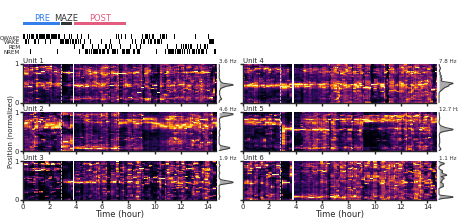

In [3]:

## Grosmark Dataset

# sample_session_index = 1 # For the main Figure 3
# units_to_plot = np.array([60, 65, 40, 74, 96, 61])-1 # AchillesMaze2

# sample_session_index = 0
# units_to_plot = np.array([56, 30, 86, 139, 72, 63])-1 # AchillesMaze1

# sample_session_index = 4
# units_to_plot = np.array([2, 17, 19, 26, 45, 11])-1 # AchillesMaze1


## Giri Dataset

# sample_session_index = 7 # Rat S
# units_to_plot = np.array([29, 44, 43, 70, 74, 59])-1

sample_session_index = 6 # Rat N
units_to_plot = np.array([33, 39, 52, 51, 60, 49])-1


## Miyawaki dataset

# sample_session_index = 11 # Roy - MAZE 1
# units_to_plot = np.array([34, 35, 42, 45, 65, 67, ])-1 # 69

# sample_session_index = 13 # TED - MAZE 2
# units_to_plot = np.array([2, 6, 14, 25, 28, 32])-1 # , 38 



data_dir = r'/home/kouroshmaboudi/Documents/Learned_tuning_Python/Datasets'
sessions = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

if sample_session_index >= 13:
    session_name = sessions[sample_session_index+2]
else:
    session_name = sessions[sample_session_index]

session_dataset_path = os.path.join(data_dir, session_name)

filename = f'{session_name}.learned_tunings_vs_time_all_offline.npy'
file_path = os.path.join(session_dataset_path, filename)
    
learned_tunings_vs_time_all_offline = np.load(file_path, allow_pickle = True).item()


# ---------------------------------------------------------------------------------------------------------------------------------------------------------------
# Define functions

def max_normalize_columns(matrix):
    """
    Takes a matrix as input and returns a new matrix where each column sums up to one (a probability distribution)
    """
    # calculate the sum of each column
    col_max = np.max(matrix, axis=0)
    
    # divide each element in a column by its sum
    normalized_matrix = matrix / col_max[np.newaxis, :]
    
    return normalized_matrix


#-----------------------------------------------------------------------------------------------------------------------------------------------------------------
# Set up figure colors and style

sns.set_style('whitegrid') # Set style and context
sns.set_context('paper')

custom_params = {"axes.spines.top": False, "axes.spines.right": False}
sns.set_theme(style="ticks", rc=custom_params)

plt.rcParams.update({
    'font.size':5,
    'axes.linewidth':1,
    'pdf.fonttype':42,
    'ps.fonttype':42,
    'axes.labelsize':6,
    'axes.titlesize':6,
    'xtick.labelsize':5,
    'ytick.labelsize':5,
    'legend.fontsize':5,
    'legend.title_fontsize':6,
    'legend.frameon': False,
    'legend.markerscale':2,
    'xtick.major.size':2,
    'ytick.major.size':2
})

epoch_colors = [
    '#005CE9', # PRE
    'black', # MAZE
    '#DD335D', # POST
    ] 


#-------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Generate the figure

# Create figure and subplots
# plotheight = 1.08
plotheight = 160
plotwidth = 330
font_size = 6


fig = plt.figure()
fig.set_size_inches([plotwidth/72, plotheight/72])
gs = GridSpec(nrows=5, ncols=5, figure=fig, width_ratios=[1, 0.08, 0.02, 1, 0.08], height_ratios = [.07, .5]+[1]*3, hspace=0.35, wspace=0.03)


epochs_time_span_in_hours = epochs[sample_session_index]/3600

t_end = learned_tunings_vs_time_all_offline['POST']['win_centers'][-1]/3600


#------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Brain state indicator bars

ax1 = fig.add_subplot(gs[1, 0])

ax1.imshow(time_bin_brain_state_2D_array[sample_session_index], extent = [time_bins_centers[sample_session_index][0]/3600, time_bins_centers[sample_session_index][-1]/3600, 0, 4], interpolation='nearest', cmap='binary', origin='lower')
ax1.set_aspect("auto")

# ax1.axis('off')
ax1.set_xlim([0, t_end])
ax1.tick_params(axis='both', which='major', labelsize=5, width=1)
ax1.set_yticks(np.array([1,2,3,4])-0.5,  brainStates_names, fontsize= 4)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.set_xticks([])
ax1.tick_params(axis='both', which='both', length=0, pad=2)


#------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Epoch time span indicator bars

ax0 = fig.add_subplot(gs[0, 0], sharex = ax1)

epochs_time_span_in_hours_including_latePOST = np.concatenate((epochs_time_span_in_hours, np.zeros((1, 2))), axis=0 )
epochs_time_span_in_hours_including_latePOST[2,1] = epochs_time_span_in_hours[2,0] + 4
epochs_time_span_in_hours_including_latePOST[3,0] = epochs_time_span_in_hours[2,0] + 4
epochs_time_span_in_hours_including_latePOST[3,1] = epochs_time_span_in_hours[2,1]

for epoch_index, epoch in enumerate(epoch_names):
    start,end = epochs_time_span_in_hours_including_latePOST[epoch_index]
    ax0.axvspan(start, end-0.02, alpha=0.8, color=epoch_colors[epoch_index], linewidth= 0)
    ax0.text(np.mean(epochs_time_span_in_hours_including_latePOST[epoch_index]), 1.3, epoch, fontsize=6, ha='center', color=epoch_colors[epoch_index], alpha=0.8)
ax0.axis('off')
ax0.set_xlim([0, t_end])


#---------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Moving-window LTs 

num_pos_bins = learned_tunings_vs_time_all_offline[epoch]['learned_tunings_all_offline_across_time'].shape[1]

ax_start_index = 2
for unit_index, unit in enumerate(units_to_plot):
    
    #------------------------------------------------------------------------------
    # Left panels: Learned tunings in 15 minutes time windows for the current unit
    
    if unit_index < 3:
        ax2 = fig.add_subplot(gs[unit_index + ax_start_index, 0])
    else:
        ax2 = fig.add_subplot(gs[unit_index-3 + ax_start_index, 3])


    for j, epoch in enumerate(epoch_names):

        LTs = learned_tunings_vs_time_all_offline[epoch]['learned_tunings_all_offline_across_time'][unit, :, :]
        LTs = max_normalize_columns(LTs)
        LTs[np.isnan(LTs)] = 0

        ax2.imshow(LTs, extent = [epochs_time_span_in_hours[j, 0], epochs_time_span_in_hours[j, 1], 0, num_pos_bins], interpolation='nearest', origin = 'lower', cmap='inferno', label=epoch) 


    ax2.set_xlim([0, t_end])
    # ax2.set_title(f"unit {unit}", loc = 'left', fontsize= 5, y=0.75)
    ax2.set_title(f"Unit {unit_index+1}", loc = 'left', fontsize= 5, y=0.82)

    ax2.set_aspect("auto")
    
    ax2.axvline(x = epochs_time_span_in_hours[1, 0], color='white', linestyle='--', linewidth=0.5)
    ax2.axvline(x = epochs_time_span_in_hours[1, 1], color='white', linestyle='--', linewidth=0.5)

    ax2.set_xticks(np.arange(0, t_end, 2))
    if unit_index in [2,5]:
        ax2.set_xlabel('Time (hour)', labelpad=0)
    else:
        ax2.set_xticklabels('')
    
    ax2.set_yticks([0, num_pos_bins])
    if unit_index < 3:
        ax2.set_yticklabels([0, 1])
    else:
        ax2.set_yticklabels([])

    if unit_index == 1:
        ax2.set_ylabel('Position (normalized)', fontsize=5, labelpad=0)

    ax2.tick_params(axis='both', which='major', labelsize=5, length=2, width=1, pad=1)

    #-------------------------------------------------------------------------------------
    # Right Panels: MAZE place fields 

    if unit_index < 3:
        ax3 = fig.add_subplot(gs[unit_index + ax_start_index, 1], sharey = ax2)
    else:
        ax3 = fig.add_subplot(gs[unit_index-3 + ax_start_index, 4], sharey = ax2)

    ax3.plot(spatial_tunings_maze[sample_session_index][unit], np.arange(num_pos_bins), color = (0.2, 0.2, 0.2), linewidth=0.75, alpha= 0.9)
    x_left = 0
    x_right = spatial_tunings_maze[sample_session_index][unit]
    
    ax3.fill_betweenx(np.arange(num_pos_bins), x_left, x_right, alpha=0.4, color = (0.2, 0.2, 0.2), linewidth=0)

    ax3.text(0, num_pos_bins+5, f'{np.amax(spatial_tunings_maze[sample_session_index][unit]):.1f} Hz', fontsize = 4, color = (0.2,0.2,0.2))

    ax3.spines['left'].set_visible(False)
    ax3.spines['bottom'].set_visible(False)
    
    ax3.tick_params(axis = 'both', which='both', bottom=False, top = False, left=False, right=False, labelbottom = False, labelleft = False)


# Adjust the subplots

plt.subplots_adjust(left=0.05, right= 0.99, bottom=0.10, top=0.9, hspace=0.1)



plt.subplots_adjust(hspace=0.5)
plt.show()


filename = f'{session_name}.Figure4_learned_example_learned_tunings_v2.pdf'
file_path = os.path.join(session_dataset_path, filename)
plt.savefig(file_path, dpi=300)


### Plot the matrix of correlation between moving time window LTs belonging to same or different epochs for the same units

In [ ]:
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------
# Set up figure colors and style

sns.set_style('whitegrid') # Set style and context
sns.set_context('paper')

custom_params = {"axes.spines.top": False, "axes.spines.right": False}
sns.set_theme(style="ticks", rc=custom_params)

plt.rcParams.update({
    'font.size':5,
    'axes.linewidth':1,
    'pdf.fonttype':42,
    'ps.fonttype':42,
    'axes.labelsize':6,
    'axes.titlesize':6,
    'xtick.labelsize':5,
    'ytick.labelsize':5,
    'legend.fontsize':5,
    'legend.title_fontsize':6,
    'legend.frameon': False,
    'legend.markerscale':2,
    'xtick.major.size':2,
    'ytick.major.size':2
})

epoch_colors = [
    '#005CE9', # PRE
    'black', # MAZE
    '#DD335D', # POST
    ] 


#-------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Generate the figure

# Create figure and subplots
plotheight = 45#70
plotwidth = 330
font_size = 6


fig = plt.figure()
fig.set_size_inches([plotwidth/72, plotheight/72])
gs = GridSpec(nrows=2, ncols=8, figure=fig, width_ratios=[0.05] + [1]*6 + [0.15], height_ratios = [0.04, 1], hspace=0.05, wspace=0.2)


for unit_index, unit in enumerate(units_to_plot):

    ax0 = fig.add_subplot(gs[1, unit_index+1])

    for epoch_x_index in range(num_epochs):
        epoch_x  = epoch_names[epoch_x_index]

        epoch_x_moving_time_window_LT = learned_tunings_vs_time_all_offline[epoch_x]['learned_tunings_all_offline_across_time']

        for epoch_y_index in range(num_epochs):
            epoch_y = epoch_names[epoch_y_index]

            epoch_y_moving_time_window_LT = learned_tunings_vs_time_all_offline[epoch_y]['learned_tunings_all_offline_across_time']
    
            curr_unit_tuning_epoch_x = np.squeeze(epoch_x_moving_time_window_LT[unit, :, :])  # learned tuning in the first epoch
            if (curr_unit_tuning_epoch_x.ndim == 1):
                curr_unit_tuning_epoch_x = curr_unit_tuning_epoch_x.reshape(-1,1)

            num_time_bins_epoch_x = curr_unit_tuning_epoch_x.shape[1]

            curr_unit_tuning_epoch_y = np.squeeze(epoch_y_moving_time_window_LT[unit, :, :])  # learned tuning in the second epoch (could be the same as first)
            if (curr_unit_tuning_epoch_y.ndim == 1):
                curr_unit_tuning_epoch_y = curr_unit_tuning_epoch_y.reshape(-1,1)
            num_time_bins_epoch_y = curr_unit_tuning_epoch_y.shape[1]

            moving_window_correlation_mat = calculate_moving_time_window_correlations(curr_unit_tuning_epoch_y, curr_unit_tuning_epoch_x)

            im = ax0.imshow(moving_window_correlation_mat, extent = [epochs_time_span_in_hours[epoch_x_index, 0], epochs_time_span_in_hours[epoch_x_index, 1], epochs_time_span_in_hours[epoch_y_index, 0], epochs_time_span_in_hours[epoch_y_index, 1]], vmin = -1, vmax=1, interpolation='nearest', origin = 'lower', cmap='coolwarm', label=epoch) 
    
    ax0.set_xlim([0, t_end])
    ax0.set_ylim([0, t_end])

    ax0.axvline(x = epochs_time_span_in_hours[1, 0], color='gray', linestyle='-', linewidth=0.5)
    ax0.axvline(x = epochs_time_span_in_hours[1, 1], color='gray', linestyle='-', linewidth=0.5)
    ax0.axhline(y = epochs_time_span_in_hours[1, 0], color='gray', linestyle='-', linewidth=0.5)
    ax0.axhline(y = epochs_time_span_in_hours[1, 1], color='gray', linestyle='-', linewidth=0.5)

    ax0.set_xticks(np.arange(0,t_end,2))
    ax0.set_yticks(np.arange(0,t_end,2))
    ax0.tick_params(axis='both', which='major', length=1, pad=1, width=1)
    ax0.set_title(f"Unit {unit_index+1}", loc = 'left', fontsize= 5, y=0.88)
    if unit_index > 0:
        ax0.set_yticklabels([])

    if unit_index == 0:
        ax0.set_xlabel('Time (hour)', labelpad=1)




# Add the colorbar
cbax = fig.add_subplot(gs[1,-1])
cbar = plt.colorbar(ax0.get_images()[0], cax=cbax, orientation='vertical', drawedges= False)
cbar.set_label('Pearson correlation\ncoefficient', fontsize=4, labelpad=1)
cbar.set_ticks([-1, 0, 1])
cbar.ax.tick_params(length=0, pad=1)
cbar.ax.yaxis.set_ticks_position('right')
cbar.outline.set_visible(False)
cbax.set_aspect(3.5)




# Epoch time span indicator bars
ax1 = fig.add_subplot(gs[0, 1], sharex = ax0)

for epoch_index, epoch in enumerate(epoch_names):
    start,end = epochs_time_span_in_hours_including_latePOST[epoch_index]
    ax1.axvspan(start, end, alpha=0.8, color=epoch_colors[epoch_index], linewidth= 0)
    
ax1.axis('off')
ax1.set_xlim([0, t_end])

ax2 = fig.add_subplot(gs[1, 0], sharey = ax0)
for epoch_index, epoch in enumerate(epoch_names):
    start,end = epochs_time_span_in_hours_including_latePOST[epoch_index]
    ax2.axhspan(start, end, alpha=0.8, color=epoch_colors[epoch_index], linewidth= 0)


# ax2.axis('off')
ax2.set_ylim([0, t_end])
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.set_aspect(2.07)

ax2.tick_params(axis = 'both', which='both', bottom=False, top = False, left=False, right=False, labelbottom = False, labelleft = False)

ax2.set_ylabel('Time (hour)', labelpad=1)


# plt.subplots_adjust(left=0.05, right= 0.93, bottom=0.15, top=0.95, hspace=0.1)
plt.subplots_adjust(left=0.05, right= 0.93, bottom=0.2, top=0.88, hspace=0.1)

plt.show()

filename = f'{session_name}.moving_window_LT_correlation_mat.pdf'
file_path = os.path.join(session_dataset_path, filename)
plt.savefig(file_path, dpi=300)


### Plot the stability versus shuffle for the example units

In [ ]:
from matplotlib.ticker import FuncFormatter

def format_ticks(x, _):
    if x == int(x):
        return str(int(x))
    else:
        return str(x)

def get_dataframe(LT_stability_data):

    df = pd.DataFrame({
        'PRE': LT_stability_data[0,0, :],
        'POST': LT_stability_data[2,2, :],
        'PRE w/ POST':LT_stability_data[0,2, :]
        })
    
    return df

sample_session_index = 1
units_to_plot = np.array([60, 65, 40, 74, 96, 61])-1 # AchillesMaze2

data_dir = r'/home/kouroshmaboudi/Documents/Learned_tuning_Python/Datasets'
sessions = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

session_name = sessions[sample_session_index]

session_dataset_path = os.path.join(data_dir, session_name)

filename = f'{session_name}.learned_tunings_stability_similarity.npy'
file_path = os.path.join(session_dataset_path, filename)

stability = np.load(file_path, allow_pickle = True).item()

mean_moving_window_correlations_data = stability['median_stability']
mean_moving_window_correlations_ui = stability['median_stability_unit_id']

mean_moving_window_correlations_ui = get_dataframe(mean_moving_window_correlations_ui)



# Plot

def plot_violin(ax, data, color):
    alpha = 0.9
    vio = sns.violinplot(data=data, cut=0, inner=None, positions = [.5, 1.5, 2.5],  color=color, bw = 0.3, linewidth=0, width= 0.4, capstyle='butt', ax=ax)

    ax.grid(axis='y', color=(.8,.8,.8), linewidth=0.5)
    for axis in ['left', 'bottom']:
        ax.spines[axis].set_linewidth(1)

    # vio.legend(loc="upper center", bbox_to_anchor=(0.5, 1.5))
    vio.set_title("")



#-----------------------------------------------------------------------------------------------------------------------------------------------------------------
# Set up figure colors and style

sns.set_style('whitegrid') # Set style and context
sns.set_context('paper')

custom_params = {"axes.spines.top": False, "axes.spines.right": False}
sns.set_theme(style="ticks", rc=custom_params)

plt.rcParams.update({
    'font.size':5,
    'axes.linewidth':1,
    'pdf.fonttype':42,
    'ps.fonttype':42,
    'axes.labelsize':6,
    'axes.titlesize':6,
    'xtick.labelsize':5,
    'ytick.labelsize':5,
    'legend.fontsize':5,
    'legend.title_fontsize':6,
    'legend.frameon': False,
    'legend.markerscale':2,
    'xtick.major.size':2,
    'ytick.major.size':2
})

#-------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Generate the figure


plotheight = 70
plotwidth = 330
font_size = 6


fig = plt.figure()
fig.set_size_inches([plotwidth/72, plotheight/72])
gs = GridSpec(nrows=2, ncols=8, figure=fig, width_ratios=[0.05] + [1]*6 + [0.15], height_ratios = [0.04, 1], hspace=0.05, wspace=0.2)


columns_to_plot = ['PRE', 'POST', 'PRE w/ POST']

for unit_idx, unit in enumerate(units_to_plot):

    ax0 = fig.add_subplot(gs[1, unit_idx+1])

    plot_violin(ax0, mean_moving_window_correlations_ui, (.55,.55,.55))
    sns.scatterplot(
        x = np.arange(3)-.1,
        y = [mean_moving_window_correlations_data[0,0, unit], mean_moving_window_correlations_data[2,2, unit], mean_moving_window_correlations_data[0,2, unit]],
        color = (.2,.2,.2),
        marker = 'o',
        edgecolor = None,
        linewidth = 0,
        s = 5,
        alpha= 0.8, 
        ax = ax0
    )

    ax0.set_ylim([-0.2, 1])
    ax0.set_yticks([0, 0.5, 1])
    ax0.yaxis.set_major_formatter(FuncFormatter(format_ticks))

    ax0.set_xticklabels(columns_to_plot,rotation=35, ha= 'right')
    
    ax0.tick_params(axis = 'both', which='major',length=1, pad=1)

    if unit_idx > 0:
        ax0.set_yticklabels([])

    if unit_idx == 0:
        ax0.set_ylabel('LT stability', labelpad=1)






plt.subplots_adjust(left=0.05, right= 0.93, bottom=0.45, top=0.95, hspace=0.1)

filename = f'{session_name}.moving_window_LT_stability_data_and_ui_example_units.pdf'
file_path = os.path.join(session_dataset_path, filename)
plt.savefig(file_path, dpi=300)



### Concatenate LT stability and fidelities across all sessions

In [5]:
# LT fidelities

learned_tunings_place_field_corr_sessions_concat = dict.fromkeys(epoch_names)
learned_tunings_place_field_corr_unit_id_shuffle_concat = dict.fromkeys(epoch_names)
lt_pf_correlation_median_across_all_sessions = dict.fromkeys(epoch_names)
lt_pf_correlation_median_across_all_sessions_pvalue = dict.fromkeys(epoch_names)

for epoch, epoch_name in enumerate(epoch_names):
    # data
    temp = []
    for session_idx in range(number_of_sessions):
        temp.append(learned_tunings_place_field_corr[session_idx][epoch_name][stable_above_1Hz_PF_unit_index[session_idx]])
    learned_tunings_place_field_corr_sessions_concat[epoch_name] = np.concatenate(temp, axis = 0)
    # learned_tunings_place_field_corr_sessions_concat[epoch_name] = learned_tunings_place_field_corr_sessions_concat[epoch_name][place_fields_sort_idx]

    # shuffle
    temp = []
    for session_idx in range(number_of_sessions):
        temp.append(learned_tunings_place_field_corr_unit_id_shuffle[session_idx][epoch_name][stable_above_1Hz_PF_unit_index[session_idx]])
    learned_tunings_place_field_corr_unit_id_shuffle_concat[epoch_name] = np.concatenate(temp, axis = 0)
    # learned_tunings_place_field_corr_unit_id_shuffle_concat[epoch_name] = learned_tunings_place_field_corr_unit_id_shuffle_concat[epoch_name][place_fields_sort_idx]


    # # calculate the p-values of place fidelities
    # lt_pf_correlation_median_across_all_sessions[epoch_name] = np.nanmedian(learned_tunings_place_field_corr_sessions_concat[epoch_name])  
    # ui_lt_pf_correlation_medians = np.nanmedian(learned_tunings_place_field_corr_unit_id_shuffle_concat[epoch_name], axis = 0)

num_units_pooled = learned_tunings_place_field_corr_sessions_concat['PRE'].shape[0]

column_names = ['PRE', 'MAZE', 'POST', 'PRE_ui', 'MAZE_ui', 'POST_ui']
data_list = []
for unit in range(num_units_pooled):
    curr_unit_data = [
        learned_tunings_place_field_corr_sessions_concat['PRE'][unit],
        learned_tunings_place_field_corr_sessions_concat['MAZE'][unit],
        learned_tunings_place_field_corr_sessions_concat['POST'][unit],
        learned_tunings_place_field_corr_unit_id_shuffle_concat['PRE'][unit],
        learned_tunings_place_field_corr_unit_id_shuffle_concat['MAZE'][unit],
        learned_tunings_place_field_corr_unit_id_shuffle_concat['POST'][unit]
    ]

    data_list.append(curr_unit_data)

LT_fidelity_df = pd.DataFrame(data_list, columns=column_names)



In [6]:
# LT stabilities

def get_dataframe(LT_stability_data):

    df = pd.DataFrame({
        'PRE': LT_stability_data[0,0, :],
        'POST': LT_stability_data[2,2, :],
        'PRE w/ POST':LT_stability_data[0,2, :]
        })
    
    return df

sessions = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
included_session_IDX = [x for x in range(17) if x not in (12, 13)]

sessions = [sessions[i] for i in included_session_IDX]

mean_moving_window_correlations_z_sessions_concat = []
mean_moving_window_correlations_z_median_sessions_concat = []

for session_idx, session_name in enumerate(sessions):

    print(session_name)

    session_dataset_path = os.path.join(data_dir, session_name)
    session_number = included_session_IDX[session_idx]

    
    filename = f'{session_name}.learned_tunings_stability_similarity.npy'
    file_path = os.path.join(session_dataset_path, filename)
    
    stability = np.load(file_path, allow_pickle = True).item()

    stable_above_1Hz_PF_unit_index = stability['stable_above_1Hz_units']
    mean_moving_window_correlations_z = stability['z_score'][:, :, stable_above_1Hz_PF_unit_index]

    mean_moving_window_correlations_z = get_dataframe(mean_moving_window_correlations_z)
    mean_moving_window_correlations_z['session_number'] = np.full((stable_above_1Hz_PF_unit_index.shape[0],), session_number)


    mean_moving_window_correlations_z_sessions_concat.append(mean_moving_window_correlations_z) 
    mean_moving_window_correlations_z_median_sessions_concat.append(np.nanmedian(mean_moving_window_correlations_z, axis= 0))

mean_moving_window_correlations_z_sessions_concat = pd.concat(mean_moving_window_correlations_z_sessions_concat, ignore_index = True)
mean_moving_window_correlations_z_median_sessions_concat = pd.DataFrame(mean_moving_window_correlations_z_median_sessions_concat, columns = mean_moving_window_correlations_z_sessions_concat.columns)

Achilles_10252013
Achilles_11012013
Buddy_06272013
Cicero_09172014
Gatsby_08282013
Kevin-maze1
RatN_Day2_2019-10-11_03-58-54
RatS-Day2-2020-11-27_10-22-29
RatU_Day2NSD_2021-07-24_08-16-38
RatV_Day1NSD_2021-10-02_08-10-23
RatV_Day3NSD_2021-10-07_08-10-12
Roy-maze1
Ted-maze1
Ted-maze2
Ted-maze3


In [13]:
def get_dataframe(LT_fidelities_stable_vs_unstable):

    epochs = []
    stability_statuses = []
    LT_fidelities = []
    LT_fidelities_ui = []

    epoch_names = LT_fidelities_stable_vs_unstable.keys()
    for epoch in epoch_names:
        for stability_status in ['stable', 'unstable']:
            curr_LT_fidelities = LT_fidelities_stable_vs_unstable[epoch][f'{stability_status}_data']
            curr_num_units = len(curr_LT_fidelities)

            curr_LT_fidelities_ui = LT_fidelities_stable_vs_unstable[epoch][f'{stability_status}_ui']
            
            LT_fidelities.append(curr_LT_fidelities)
            LT_fidelities_ui.append(curr_LT_fidelities_ui)
            epochs.append([epoch]*curr_num_units)
            stability_statuses.append([stability_status]*curr_num_units)
            

    LT_fidelities = np.concatenate(LT_fidelities, axis = 0)
    LT_fidelities_ui = np.concatenate(LT_fidelities_ui, axis = 0)
    epochs = np.concatenate(epochs, axis = 0)
    stability_statuses = np.concatenate(stability_statuses, axis = 0)


    df = pd.DataFrame({
        'epoch': epochs,
        'stability_status':stability_statuses,
        'LT_fidelity': LT_fidelities,
        'LT_fidelity_ui': LT_fidelities_ui
    })

    return df



stability_z_threshold = 2

sleep_epoch_names = ['PRE', 'POST']

stable_units = dict.fromkeys(sleep_epoch_names)
unstable_units = dict.fromkeys(sleep_epoch_names)
num_stable_units = dict.fromkeys(sleep_epoch_names)
num_unstable_units = dict.fromkeys(sleep_epoch_names)

LT_fidelities_stable_vs_unstable = dict.fromkeys(sleep_epoch_names)

for epoch_index, epoch in enumerate(sleep_epoch_names):

    stable_units[epoch] = []
    unstable_units[epoch] = []

    LT_fidelities_stable_vs_unstable[epoch] = dict.fromkeys(['stable_data', 'unstable_data', 'stable_ui', 'unstable_ui'])

    for session_idx, session_name in enumerate(sessions):
        session_number = included_session_IDX[session_idx]
        curr_session_unit_index = mean_moving_window_correlations_z_sessions_concat['session_number'] == session_number

        stable_units_curr_session = np.where(
                (mean_moving_window_correlations_z_sessions_concat[epoch] > stability_z_threshold) &
                (curr_session_unit_index == True)
        )[0]

        unstable_units_curr_session = np.where(
                (mean_moving_window_correlations_z_sessions_concat[epoch] <= stability_z_threshold) &
                (curr_session_unit_index == True)
        )[0]

        stable_units[epoch].append(stable_units_curr_session)
        unstable_units[epoch].append(unstable_units_curr_session)

    stable_units[epoch] = np.concatenate(stable_units[epoch], axis= 0)
    unstable_units[epoch] = np.concatenate(unstable_units[epoch], axis= 0)

    num_stable_units[epoch] = stable_units[epoch].shape[0]
    num_unstable_units[epoch] = unstable_units[epoch].shape[0]


    LT_fidelities_stable_vs_unstable[epoch]['stable_data'] = LT_fidelity_df.loc[stable_units[epoch], epoch].values
    LT_fidelities_stable_vs_unstable[epoch]['stable_ui'] = LT_fidelity_df.loc[stable_units[epoch], f'{epoch}_ui'].values

    LT_fidelities_stable_vs_unstable[epoch]['unstable_data'] = LT_fidelity_df.loc[unstable_units[epoch], epoch].values
    LT_fidelities_stable_vs_unstable[epoch]['unstable_ui'] = LT_fidelity_df.loc[unstable_units[epoch], f'{epoch}_ui'].values


# aa = LT_fidelities_stable_vs_unstable.copy()
LT_fidelities_stability_split =  get_dataframe(LT_fidelities_stable_vs_unstable)

In [15]:
num_unstable_units

{'PRE': 289, 'POST': 206}

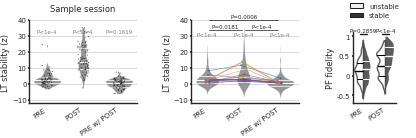

In [20]:
from scipy.stats import wilcoxon, ranksums
from matplotlib.ticker import FuncFormatter



def get_pval_statement(pvalue):
    if pvalue < 0.0001:
        pvalue_statement = 'P<1e-4'
    else:
        pvalue_statement = f'P={pvalue:.4f}'
    return pvalue_statement

def format_ticks(x, _):
    if x == int(x):
        return str(int(x))
    else:
        return str(x)

def plot_violin(ax, data, color):
    alpha = 0.9
    vio = sns.violinplot(data=data, cut=0, inner='quartiles', ax=ax, color=color, bw = 0.25, linewidth=0, width= 0.75, capstyle='butt')

    for violin, curr_alpha in zip(ax.collections[::1], [alpha] * 6):
        violin.set_alpha(curr_alpha)
    for l in ax.lines:
        l.set_linestyle('-')
        l.set_linewidth(0.5)
        l.set_color('white')
        l.set_alpha(1)
    for l in ax.lines[1::3]:
        l.set_linestyle('-')
        l.set_linewidth(.75)
        l.set_color('white')
        l.set_alpha(1)
    ax.grid(axis='y', color=(.8,.8,.8), linewidth=0.5)
    for axis in ['left', 'bottom']:
        ax.spines[axis].set_linewidth(1)

    # vio.legend(loc="upper center", bbox_to_anchor=(0.5, 1.5))
    vio.set_title("")

def plot_violin2(ax, data, color):
    alpha = 0.8

    vio = sns.violinplot(data = data, x = 'epoch', y = 'LT_fidelity', hue = 'stability_status', color = color, hue_order = ['unstable', 'stable'], split=True, bw = 0.2, cut=0, inner='quartiles', capstyle='butt', ax = ax2)

    for violin, curr_alpha in zip(ax.collections[::2], [alpha] * 4):
        violin.set_alpha(curr_alpha)

    for l in ax.lines: # quartile lines
        l.set_linestyle('-')
        l.set_linewidth(0.75)

    for l in ax.lines[1::3]: # median lines
        l.set_linestyle('-')
        l.set_linewidth(1)

    for i, l in enumerate(ax.lines):
        if i % 6 < 3: 
            l.set_color('black')
        else: 
            l.set_color('white')

    # ax.grid(axis='y', color='gray', linewidth=1)
    for axis in ['left', 'bottom']:
        ax.spines[axis].set_linewidth(1)

    violin_elements = vio.collections
    for i, elem in enumerate(violin_elements):
        if i % 2 == 0:  # Even indices (left side of the violin)
            elem.set_facecolor("none")  # Empty fill
            elem.set_edgecolor(color)  # Outline color
            elem.set_linewidth(1)
        else:  # Odd indices (right side of the violin)
            elem.set_facecolor(color)  # Filled with the same color
            elem.set_edgecolor("none")

    vio.legend(loc="upper center", bbox_to_anchor=(0.5, 1.5), fontsize = 5)
    vio.set_title("")


#-----------------------------------------------------------------------------------------------------------------------------------------------------------------
# Set up figure colors and style

sns.set_style('whitegrid') 
sns.set_context('paper')

custom_params = {
    "axes.spines.top": False,
    "axes.spines.right": False
    }

sns.set_theme(style="ticks", rc=custom_params)

plt.rcParams.update({
    'font.size':6,
    'axes.linewidth':0.75,
    'pdf.fonttype':42,
    'ps.fonttype':42,
    'axes.labelsize':6,
    'axes.titlesize':6,
    'xtick.labelsize':5,
    'ytick.labelsize':5,
    'legend.fontsize':6,
    'legend.title_fontsize':6,
    'legend.frameon': False,
    'legend.markerscale':2,
    'xtick.major.size':2,
    'ytick.major.size':2
})

dataset_specific_colors = ["#E58044", "#046C7C", "#85459B"] # , 


#-------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Generate the figure


plotheight = 100
plotwidth = 300
font_size = 5

fig = plt.figure()
fig.set_size_inches([plotwidth/72, plotheight/72])
gs = GridSpec(nrows=7, ncols=12, figure=fig, hspace=0.3, wspace=2)

columns_to_plot = ['PRE', 'POST', 'PRE w/ POST']

#--------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Sample session *Panel d*

ax_0 = fig.add_subplot(gs[:, 0:4])

sample_session_index = 1

curr_row_indexes = np.where(mean_moving_window_correlations_z_sessions_concat['session_number'] == sample_session_index)[0]
curr_data_to_plot = mean_moving_window_correlations_z_sessions_concat.loc[curr_row_indexes, columns_to_plot]

plot_violin(ax_0, curr_data_to_plot, (.55,.55,.55))
sns.stripplot(data=curr_data_to_plot, jitter = 0.15, palette='dark:k', size=0.8, alpha=0.8)

medians = np.empty((3,))
for column_index, column in enumerate(columns_to_plot):
    _,p_value = wilcoxon(curr_data_to_plot[column])
    medians[column_index] = np.nanmedian(curr_data_to_plot[column])
    ax_0.text(column_index, 32, get_pval_statement(p_value), fontsize=4, ha = 'center', color = 'gray')


ax_0.set_ylim([-12, 40])
ax_0.set_ylabel('LT stability (z)', labelpad=1)
ax_0.set_title('Sample session')


ax_0.set_xticklabels(columns_to_plot,rotation=35, ha= 'right')
ax_0.set_yticks(np.arange(-10, 40.01, 10))

ax_0.tick_params(axis = 'both', which='major',length=1, pad=1)



#------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Pooled results *Panel e*

ax_1 = fig.add_subplot(gs[:, 5:9])

plot_violin(ax_1, mean_moving_window_correlations_z_sessions_concat[columns_to_plot], (.55,.55,.55))

# Plot the medians

# # other sessions
# other_sessions_indexes = np.setdiff1d(included_session_IDX, sample_session_index)
# row_indexes = mean_moving_window_correlations_z_median_sessions_concat['session_number'].isin(other_sessions_indexes)

# jitter = 0.2

# for column_index, column in enumerate(columns_to_plot):
#     current_jitter = np.random.uniform(-jitter, jitter, len(other_sessions_indexes))
#     sns.scatterplot(x = column_index+current_jitter, y = mean_moving_window_correlations_z_median_sessions_concat.loc[row_indexes, column], color = 'white', alpha=0.7,  s = 1.5, edgecolor='black', linewidth = 0.3, zorder= 2) 


# # sample session
# row_index = mean_moving_window_correlations_z_median_sessions_concat['session_number'] == sample_session_index
# sns.stripplot(data = mean_moving_window_correlations_z_median_sessions_concat.loc[row_index, columns_to_plot], jitter = 0.2, palette = 'dark:k', size=1.54, alpha=0.8)

jitter = 0.075
for session_idx in range(number_of_sessions):
    session_number = included_session_IDX[session_idx]

    if session_number in range(5):
        color = dataset_specific_colors[0]
    elif session_number in range(6,11):
        color = dataset_specific_colors[1]
    else:
        color = dataset_specific_colors[2]

    if session_number == sample_session_index:
        linewidth = 0.75
        marker_size = 3
        z_order = 5
        alpha = 0.8
    else:
        linewidth = 0.5
        marker_size = 2
        z_order = 4
        alpha = 0.6

    row_index = mean_moving_window_correlations_z_median_sessions_concat['session_number'] == session_number
    current_x_location = np.arange(3)+np.random.uniform(-jitter, jitter, 3)
    current_y_values = mean_moving_window_correlations_z_median_sessions_concat.loc[row_index, columns_to_plot].values.flatten()
    ax_1.plot(current_x_location, current_y_values, color = color, linewidth = linewidth, alpha=alpha, zorder = z_order)
    sns.scatterplot(x = current_x_location, y = current_y_values, color = color, alpha=alpha,  s = marker_size, edgecolor='None', linewidth = 0, zorder= z_order) 



# Wilcoxon tests

# For each column's difference from zero
pooled_medians = np.empty((3,))
for column_index, column in enumerate(columns_to_plot):
    pooled_medians[column_index] = np.nanmedian(mean_moving_window_correlations_z_median_sessions_concat[column])
    _, p_value = wilcoxon(mean_moving_window_correlations_z_median_sessions_concat[column])
    ax_1.text(column_index, 30, get_pval_statement(p_value), fontsize = 4, ha = 'center', color = 'gray')


# Between the columns
for column_i_index in range(len(columns_to_plot)):
    column_i = columns_to_plot[column_i_index]

    t = 0
    for column_j_index in range(column_i_index+1, len(columns_to_plot)):
        column_j = columns_to_plot[column_j_index]

        _, p_value = wilcoxon(mean_moving_window_correlations_z_median_sessions_concat[column_i], mean_moving_window_correlations_z_median_sessions_concat[column_j])

        y = 34+t*6
        ax_1.plot([column_i_index+0.05, column_j_index-0.05], [y,y], color = 'k', linewidth=0.5)
        ax_1.text(np.mean([column_i_index, column_j_index]), 35+t*6, get_pval_statement(p_value), fontsize=4, ha = 'center')

        t =+ 1


ax_1.set_ylim([-12, 40])
ax_1.set_ylabel('LT stability (z)', labelpad=1)


ax_1.set_xticklabels(columns_to_plot,rotation=35, ha= 'right')
ax_1.set_yticks(np.arange(-10, 40.01, 10))

ax_1.tick_params(axis = 'both', which='major',length=1, pad=1)


#---------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Relationship between stability and fidelity * Panel f*

# Divide the units into stable and unstable categories and compare the PF fidelity between them

ax2 = fig.add_subplot(gs[1:, 10:])

plot_violin2(ax2, LT_fidelities_stability_split, (.2,.2,.2,.8))

ax2.set_xlabel('')
ax2.set_ylabel('PF fidelity', labelpad=1)
ax2.tick_params(axis='both', which='major', labelsize=5, length=1, pad=1)
ax2.yaxis.set_major_formatter(FuncFormatter(format_ticks))
ax2.set_xticklabels(sleep_epoch_names,rotation=35, ha= 'right')
ax2.set_ylim([-0.7, 1.1])



# Statistal tests of the medians and their differences
median_fidelity_stable_group = dict.fromkeys(sleep_epoch_names)
iqr_fidelity_stable_group = dict.fromkeys(sleep_epoch_names) #interquartile range
p_value_fidelity_stable_group = dict.fromkeys(sleep_epoch_names)

median_fidelity_unstable_group = dict.fromkeys(sleep_epoch_names)
iqr_fidelity_unstable_group = dict.fromkeys(sleep_epoch_names)
p_value_fidelity_unstable_group = dict.fromkeys(sleep_epoch_names)


for epoch_index, epoch in enumerate(sleep_epoch_names):

    stable_group = (
        (LT_fidelities_stability_split['epoch'] == epoch) &
        (LT_fidelities_stability_split['stability_status'] == 'stable')
    )
    stable_fidelities = LT_fidelities_stability_split.loc[stable_group, 'LT_fidelity']
    median_fidelity_stable_group[epoch] = np.nanmedian(stable_fidelities , axis = 0)
    iqr_fidelity_stable_group[epoch] = np.nanpercentile(stable_fidelities, 75) - np.nanpercentile(stable_fidelities, 25)


    ui_fidelities_stable_group = np.stack(LT_fidelities_stability_split.loc[stable_group, 'LT_fidelity_ui'].to_numpy(), axis = 0)
    ui_median_fidelity_stable_group = np.nanmedian(ui_fidelities_stable_group, axis = 0)

    p_value_fidelity_stable_group[epoch] = np.sum(ui_median_fidelity_stable_group >= median_fidelity_stable_group[epoch])/num_shuffles



    unstable_group = (
        (LT_fidelities_stability_split['epoch'] == epoch) &
        (LT_fidelities_stability_split['stability_status'] == 'unstable')
    )
    unstable_fidelities = LT_fidelities_stability_split.loc[unstable_group, 'LT_fidelity']
    median_fidelity_unstable_group[epoch] = np.nanmedian(unstable_fidelities , axis = 0)
    iqr_fidelity_unstable_group[epoch] = np.nanpercentile(unstable_fidelities, 75) - np.nanpercentile(unstable_fidelities, 25)


    ui_fidelities_unstable_group = np.stack(LT_fidelities_stability_split.loc[unstable_group, 'LT_fidelity_ui'].to_numpy(), axis = 0)
    ui_median_fidelity_unstable_group = np.nanmedian(ui_fidelities_unstable_group, axis = 0)

    p_value_fidelity_unstable_group[epoch] = np.sum(ui_median_fidelity_unstable_group >= median_fidelity_unstable_group[epoch])/num_shuffles




    _, p_value = ranksums(stable_fidelities, unstable_fidelities)

    y = 1.05
    ax2.plot([epoch_index-0.15, epoch_index+0.15], [y,y], color = 'k', linewidth=1)
    ax2.text(epoch_index, 1.1, get_pval_statement(p_value), fontsize=4, ha = 'center')




plt.subplots_adjust(left=0.07, right= 0.95, bottom=0.25, top=0.85)

filename = 'Figure3_panels_e_f_v2'
file_path = os.path.join(data_dir, filename)
plt.savefig(file_path, format='pdf', dpi=300)




In [24]:
p_value_fidelity_unstable_group

{'PRE': 0.3537, 'POST': 0.0002}

In [ ]:
# load REM learned tunings calculated in MATLAB

num_shuffles = 10000

for session_idx in range(number_of_sessions):

    session_number = current_sessions[session_idx]
    session_name = rr[session_number]


    session_dataset_path = os.path.join(main_dir, session_name)

    filename = f'{session_name}.assemblyTunings_REM_0.020.mat'
    file_path = os.path.join(session_dataset_path, 'NREM_REM_with_posterior_ginis', filename)
    mat_file = loadmat(file_path)
    
    for epoch in ['pre', 'post']:
    
        original_learned_tunings = mat_file['assemblyTunings'][epoch][0][0][0][0][0]

        gini_coeffs[session_idx][epoch]['REM'] = mat_file['posteriors_gini_coeffs'][epoch][0][0]

        num_units, num_pos_bins = original_learned_tunings.shape

        interp_pos_bins = np.linspace(0, num_pos_bins, 200)
        num_pos_bins_interp = len(interp_pos_bins)
    

        learned_tunings[session_idx][epoch]['REM'] = np.full((num_units, num_pos_bins_interp), np.nan)

        for unit in range(num_units):
            current_unit_lt = original_learned_tunings[unit].reshape(num_pos_bins)
            current_unit_lt = np.interp(interp_pos_bins, np.arange(0, num_pos_bins), current_unit_lt)
            current_unit_lt[np.isnan(current_unit_lt)] = 0

            learned_tunings[session_idx][epoch]['REM'][unit] = np.convolve(current_unit_lt, gw, mode='same')


        learned_tunings_place_field_corr[session_idx][epoch]['REM'] = np.full((num_units,), np.nan)
        learned_tunings_place_field_corr[session_idx][epoch]['REM'][stable_above_1Hz_PF_unit_index[session_idx]], _, _ = calculate_place_field_fidelity_of_learned_tuning(
                    learned_tunings[session_idx][epoch]['REM'][stable_above_1Hz_PF_unit_index[session_idx]],
                    spatial_tunings_maze[session_idx][stable_above_1Hz_PF_unit_index[session_idx]],  
                    num_shuffles
                )


/home/kouroshmaboudi/miniconda3/envs/learned_tuning_project_env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


### Moving time window LTs' PF fidelities

In [219]:
num_epochs = len(epoch_names)

#------------------------------------------------------------------------------------------------------------------------------------------------
# Calculate the z-scored moving time window LT fidelity for each session

sessions = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
included_session_IDX = [x for x in range(17) if x not in (12, 13)]

total_num_sessions = len(included_session_IDX)

# included_session_IDX = np.arange(6,11)

sessions = [sessions[i] for i in included_session_IDX]

moving_time_window_centers = [None]*len(sessions)
moving_time_window_LTs = [None]*len(sessions)
moving_time_window_LT_median_fidelity_z_score = [None]*len(sessions)

for session_idx, session_name in enumerate(sessions):

    session_dataset_path = os.path.join(data_dir, session_name)
    session_number = included_session_IDX[session_idx]

    
    filename = f'{session_name}.learned_tunings_vs_time_all_offline.npy'
    file_path = os.path.join(session_dataset_path, filename)
        
    learned_tunings_vs_time_all_offline = np.load(file_path, allow_pickle = True).item()


    moving_time_window_centers[session_idx] = dict.fromkeys(epoch_names)
    
    moving_time_window_LTs[session_idx] = dict.fromkeys(epoch_names)
    moving_time_window_LT_median_fidelity_z_score[session_idx] = dict.fromkeys(epoch_names)


    for epoch_index, epoch in enumerate(epoch_names):
        
        win_centers = learned_tunings_vs_time_all_offline[epoch]['win_centers']
        moving_window_LT_fidelity = learned_tunings_vs_time_all_offline[epoch]['median_LT_PF_pearson_corr_all_offline_across_time']

        moving_time_window_centers[session_idx][epoch] = win_centers/3600 # in hours
        
        moving_time_window_LTs[session_idx][epoch] = learned_tunings_vs_time_all_offline[epoch]['learned_tunings_all_offline_across_time']

        moving_time_window_LT_median_fidelity_z_score[session_idx][epoch] = np.full((win_centers.shape[0],), np.nan)
        for time_window_index, time_window in enumerate(win_centers):
            
            time_window_LT_fidelity_data = moving_window_LT_fidelity[time_window_index]['data']
            time_window_LT_fidleity_ui = moving_window_LT_fidelity[time_window_index]['PF_unit_IDX_shuffle']

            moving_time_window_LT_median_fidelity_z_score[session_idx][epoch][time_window_index] = (time_window_LT_fidelity_data - np.nanmean(time_window_LT_fidleity_ui))/np.nanstd(time_window_LT_fidleity_ui)


#-------------------------------------------------------------------------------------------------------------------------------------------------
# Align the time bin centers within each epoch across all sessions

# PRE time bin centers to the start of MAZE
# MAZE time bin centers to the start of MAZE
# POST time bin centers to the end of MAZE

sessions_by_datasets = [None]*4 # there are three datasets: Grosmark, Giri, and Miyawaki datasets plus one additional set of indexes encompassing all sessions
sessions_by_datasets[0] = np.arange(5)
sessions_by_datasets[1] = np.arange(6,11)
sessions_by_datasets[2] = np.setdiff1d(np.arange(15), np.concatenate(sessions_by_datasets[:2]))
sessions_by_datasets[3] = np.arange(15)

win_step_size = 1/12 # in hours


num_windows_indiv_sessions = dict.fromkeys(epoch_names)
for epoch in epoch_names:
    num_windows_indiv_sessions[epoch] = np.full((total_num_sessions,), np.nan, dtype=int)
    for session_idx in range(total_num_sessions):
        num_windows_indiv_sessions[epoch][session_idx] = len(moving_time_window_centers[session_idx][epoch])



max_num_windows_across_sessions = [None]*4
moving_time_window_centers_aligned = [None]*4


# Aligning each set of session indexes separately
for dataset_index in range(4):

    current_dataset_session_indexes = sessions_by_datasets[dataset_index]

    max_num_windows_across_sessions[dataset_index] = dict.fromkeys(epoch_names)


    moving_time_window_centers_aligned[dataset_index] = dict.fromkeys(epoch_names) # aligned specifically for each dataset 

    for epoch_index, epoch in enumerate(epoch_names):

        if epoch_index == 0:
            curr_epoch_aligned_start = 0
        else:
            prev_epoch = epoch_names[epoch_index-1]
            curr_epoch_aligned_start = moving_time_window_centers_aligned[dataset_index][prev_epoch][-1]

        max_num_windows_across_sessions[dataset_index][epoch] = np.amax(num_windows_indiv_sessions[epoch][current_dataset_session_indexes])
        moving_time_window_centers_aligned[dataset_index][epoch] = curr_epoch_aligned_start + np.arange(max_num_windows_across_sessions[dataset_index][epoch])*win_step_size + win_step_size/2



# Align the LT fidelities across all sessions within all datasets

moving_window_LT_fidelities_time_windows_aligned = dict.fromkeys(epoch_names) # aligned across all sessions (including all datasets) - the 4th set of sessions indexes will be used for calculating this

dataset_index = 3
for epoch_index, epoch in enumerate(epoch_names):

    moving_window_LT_fidelities_time_windows_aligned[epoch] = [None]*total_num_sessions
    for session_idx in sessions_by_datasets[dataset_index]:
    
        num_units, num_pos_bins,_ = moving_time_window_LTs[session_idx][epoch].shape

        if epoch == 'PRE':  # aligning all sessions to the end of the epoch 
            current_session_aligned_time_window_indexes = np.arange((max_num_windows_across_sessions[dataset_index][epoch] - num_windows_indiv_sessions[epoch][session_idx]), max_num_windows_across_sessions[dataset_index][epoch])
        else:  # for MAZE and POST aligning to the start of the epoch
            current_session_aligned_time_window_indexes = np.arange(num_windows_indiv_sessions[epoch][session_idx])

        moving_window_LT_fidelities_time_windows_aligned[epoch][session_idx] = np.full((max_num_windows_across_sessions[dataset_index][epoch],), np.nan)
        moving_window_LT_fidelities_time_windows_aligned[epoch][session_idx][current_session_aligned_time_window_indexes] = moving_time_window_LT_median_fidelity_z_score[session_idx][epoch]




In [ ]:
# Calculate the average moving time window correlation matrices separately for each dataset

num_shuffles = 500

moving_window_LTs_time_windows_aligned = dict.fromkeys(epoch_names)

for epoch in epoch_names:
    moving_window_LTs_time_windows_aligned[epoch] = [None]*total_num_sessions

moving_window_correlation_mat_data = [None]*total_num_sessions
moving_window_correlation_mat_ui = [None]*total_num_sessions
moving_window_correlation_mat_z_score = [None]*total_num_sessions

for dataset_index in range(3):

    current_dataset_session_indexes = sessions_by_datasets[dataset_index]


    epoch_start_time_bin = dict.fromkeys(epoch_names)
    for epoch_index, epoch in enumerate(epoch_names):
        if epoch_index == 0:
            epoch_start_time_bin['PRE'] = 0
        else: 
            prev_epoch = epoch_names[epoch_index-1]
            epoch_start_time_bin[epoch] = epoch_start_time_bin[prev_epoch] + max_num_windows_across_sessions[dataset_index][prev_epoch]

    num_time_bins_summed_over_epochs = max_num_windows_across_sessions[dataset_index]['PRE'] + max_num_windows_across_sessions[dataset_index]['MAZE'] + max_num_windows_across_sessions[dataset_index]['POST']


    for session_idx in current_dataset_session_indexes:


        print(sessions[session_idx])

        num_units, num_pos_bins, _ = moving_time_window_LTs[session_idx]['PRE'].shape

        

        # Align the moving window LTs
        for epoch in epoch_names:

            if epoch == 'PRE':  # aligning all sessions to the end of the epoch 
                current_session_aligned_time_window_indexes = np.arange((max_num_windows_across_sessions[dataset_index][epoch] - num_windows_indiv_sessions[epoch][session_idx]), max_num_windows_across_sessions[dataset_index][epoch])
            else:  # for MAZE and POST aligning to the start of the epoch
                current_session_aligned_time_window_indexes = np.arange(num_windows_indiv_sessions[epoch][session_idx])

            moving_window_LTs_time_windows_aligned[epoch][session_idx] = np.full((num_units, num_pos_bins, max_num_windows_across_sessions[dataset_index][epoch]), np.nan)
            moving_window_LTs_time_windows_aligned[epoch][session_idx][:, :, current_session_aligned_time_window_indexes] = moving_time_window_LTs[session_idx][epoch]



        moving_window_correlation_mat_data[session_idx] = np.full((num_time_bins_summed_over_epochs, num_time_bins_summed_over_epochs, num_units), np.nan)
        moving_window_correlation_mat_ui[session_idx] = np.full((num_time_bins_summed_over_epochs, num_time_bins_summed_over_epochs, num_shuffles), np.nan)
        # moving_window_correlation_mat_z_score[session_idx] = np.full((num_time_bins_summed_over_epochs, num_time_bins_summed_over_epochs, num_units), np.nan)

        for epoch_x_index in range(num_epochs):
            epoch_x  = epoch_names[epoch_x_index]

            epoch_x_moving_time_window_LT = moving_window_LTs_time_windows_aligned[epoch_x][session_idx]
            slice_start_x = epoch_start_time_bin[epoch_x] 
            slice_stop_x = slice_start_x + max_num_windows_across_sessions[dataset_index][epoch_x]

            for epoch_y_index in range(epoch_x_index, num_epochs):
                epoch_y = epoch_names[epoch_y_index]
                print(epoch_x + ' vs ' + epoch_y)

                epoch_y_moving_time_window_LT = moving_window_LTs_time_windows_aligned[epoch_y][session_idx]
                slice_start_y = epoch_start_time_bin[epoch_y] 
                slice_stop_y = slice_start_y + max_num_windows_across_sessions[dataset_index][epoch_y]


                # Data
                # print('Data ...')

                for unit in stable_above_1Hz_PF_unit_index[session_idx]:

                    curr_unit_tuning_epoch_x = np.squeeze(epoch_x_moving_time_window_LT[unit, :, :])  # learned tuning in the first epoch
                    if (curr_unit_tuning_epoch_x.ndim == 1):
                        curr_unit_tuning_epoch_x = curr_unit_tuning_epoch_x.reshape(-1,1)

                    curr_unit_tuning_epoch_y = np.squeeze(epoch_y_moving_time_window_LT[unit, :, :])  # learned tuning in the second epoch (could be the same as first)
                    if (curr_unit_tuning_epoch_y.ndim == 1):
                        curr_unit_tuning_epoch_y = curr_unit_tuning_epoch_y.reshape(-1,1)

                    curr_moving_window_corr_mat = calculate_moving_time_window_correlations(curr_unit_tuning_epoch_y, curr_unit_tuning_epoch_x)
                    
                    moving_window_correlation_mat_data[session_idx][
                        slice_start_y: slice_stop_y,
                        slice_start_x: slice_stop_x, unit] = curr_moving_window_corr_mat
                    
                    if epoch_x != epoch_y:
                        moving_window_correlation_mat_data[session_idx][
                            slice_start_x: slice_stop_x,
                            slice_start_y: slice_stop_y, unit] = np.transpose(curr_moving_window_corr_mat)
                        

                # Shuffle
                # print('Shuffle ...')

                num_time_bins_epoch_x = epoch_x_moving_time_window_LT.shape[2]
                shuffled_units_epoch_x = np.random.choice(stable_above_1Hz_PF_unit_index[session_idx], size=(num_shuffles, num_time_bins_epoch_x))

                num_time_bins_epoch_y = epoch_y_moving_time_window_LT.shape[2]
                shuffled_units_epoch_y = np.random.choice(stable_above_1Hz_PF_unit_index[session_idx], size=(num_shuffles, num_time_bins_epoch_y))
                

                for shuffle_index in range(num_shuffles):

                    # Generate shuffle tunings by randomly choosing a unit within every time bin 
                    shuffled_epoch_x_moving_time_window_LT = np.zeros((num_pos_bins, num_time_bins_epoch_x))
                    for time_bin_index in range(num_time_bins_epoch_x):
                        shuffled_epoch_x_moving_time_window_LT[:, time_bin_index] = np.squeeze(epoch_x_moving_time_window_LT[shuffled_units_epoch_x[shuffle_index, time_bin_index], :,  time_bin_index])


                    shuffled_epoch_y_moving_time_window_LT = np.zeros((num_pos_bins, num_time_bins_epoch_y))
                    for time_bin_index in range(num_time_bins_epoch_y):
                        shuffled_epoch_y_moving_time_window_LT[:, time_bin_index] = np.squeeze(epoch_y_moving_time_window_LT[shuffled_units_epoch_y[shuffle_index, time_bin_index], :,  time_bin_index])

                    
                    curr_moving_window_corr_mat = calculate_moving_time_window_correlations(shuffled_epoch_y_moving_time_window_LT, shuffled_epoch_x_moving_time_window_LT)
                    
                    moving_window_correlation_mat_ui[session_idx][
                        slice_start_y: slice_stop_y,
                        slice_start_x: slice_stop_x, shuffle_index] = curr_moving_window_corr_mat
                    
                    if epoch_x != epoch_y:
                        moving_window_correlation_mat_ui[session_idx][
                            slice_start_x: slice_stop_x,
                            slice_start_y: slice_stop_y, shuffle_index] = np.transpose(curr_moving_window_corr_mat)
                            


        mean_array = np.nanmean(moving_window_correlation_mat_ui[session_idx], axis=2)
        std_array = np.nanstd(moving_window_correlation_mat_ui[session_idx], axis=2)

        mean_array = np.repeat(mean_array[:,:, np.newaxis], num_units, axis = 2)
        std_array = np.repeat(std_array[:,:, np.newaxis], num_units, axis = 2)

        moving_window_correlation_mat_z_score[session_idx] = (
            moving_window_correlation_mat_data[session_idx] - mean_array
        ) / std_array


    # moving_window_correlation_mat_pooled = np.concatenate(moving_window_correlation_mat_z_score, axis = 2)


In [ ]:
import matplotlib.ticker as ticker
from scipy.stats import wilcoxon

def remove_trailing_zeros(x, pos):
    formatted_label = f"{int(x):d}" if x == int(x) else f"{x:.1f}"
    return formatted_label


def get_pval_statement(pvalue):
    if pvalue < 0.0001:
        pvalue_statement = '**'
    else:
        pvalue_statement = f'P={pvalue:.4f}'
    return pvalue_statement

#-----------------------------------------------------------------------------------------------------------------------------------------------------------------
# Set up figure colors and style

sns.set_style('whitegrid') 
sns.set_context('paper')

custom_params = {
    "axes.spines.top": False,
    "axes.spines.right": False
    }

sns.set_theme(style="ticks", rc=custom_params)

plt.rcParams.update({
    'font.size':5,
    'axes.linewidth':0.5,
    'pdf.fonttype':42,
    'ps.fonttype':42,
    'axes.labelsize':5,
    'axes.titlesize':5,
    'xtick.labelsize':5,
    'ytick.labelsize':5,
    'legend.fontsize':5,
    'legend.title_fontsize':6,
    'legend.frameon': False,
    'legend.markerscale':2,
    'xtick.major.size':2,
    'ytick.major.size':2
})


epoch_colors = [
    '#005CE9', # PRE
    'black', # MAZE
    '#DD335D', # POST
    ] 

dataset_names = ['Grosmark_dataset', 'Giri_dataset', 'Miyawaki_dataset']
dataset_specific_colors = ["#E58044", "#046C7C", "#85459B"] # , 

#--------------------------------------------------------------------------------------------------------------------------------------------------------------------

total_num_time_windows_aligned = np.full((3,), np.nan)
for dataset_index in range(3):
    total_num_time_windows_aligned[dataset_index] = max_num_windows_across_sessions[dataset_index]['PRE'] + max_num_windows_across_sessions[dataset_index]['MAZE'] + max_num_windows_across_sessions[dataset_index]['POST']

max_total_num_time_windows_across_datasets = np.max(total_num_time_windows_aligned)

#--------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Plot the moving window LT correlation matrices separately for each dataset

epoch_indicator_bar_width = 0.03
epoch_indicator_bar_pad = 0.02
epoch_indicator_bar_total_width = epoch_indicator_bar_width + epoch_indicator_bar_pad

z_score_stability_time_window_aligned = [None]*3

for dataset_index, dataset_name in enumerate(dataset_names):

    current_session_indexes = sessions_by_datasets[dataset_index]


    plotwidth = 110
    plotheight = 70
    
    fig = plt.figure()
    fig.set_size_inches([plotwidth/72, plotheight/72])
    gs = GridSpec(nrows= 1, ncols=2, figure=fig, width_ratios = [0.5, 0.5], hspace=0.2, wspace=0.5)

    # Moving time window LT correlation matrix

    ax1 = fig.add_subplot(gs[0])

    ax1.set_aspect('equal')
    ax1.axis('off')

    ratio = total_num_time_windows_aligned[dataset_index]/max_total_num_time_windows_across_datasets
    ax1 = ax1.inset_axes([(1-ratio)/2,(1-ratio)/2, ratio, ratio])
    ax1.axis('off')

    ax1.set_title(dataset_name.replace('_', ' '), fontsize=5, pad = 3)

    corr_mat_ax = ax1.inset_axes([epoch_indicator_bar_total_width, epoch_indicator_bar_total_width, 1-epoch_indicator_bar_total_width, 1-epoch_indicator_bar_total_width])
    
    moving_window_correlation_mat_pooled = np.concatenate([moving_window_correlation_mat_z_score[x] for x in current_session_indexes], axis = 2)
    moving_window_correlation_mat_pooled_mean = np.nanmean(moving_window_correlation_mat_pooled, axis=2)
    # moving_window_correlation_mat_pooled_mean[np.isnan(moving_window_correlation_mat_pooled_mean)] = 0 # replace nan with zeros


    corr_mat_ax.imshow(moving_window_correlation_mat_pooled_mean, vmin=-1, vmax = 1, cmap = 'coolwarm', origin='lower', interpolation='None')

    print(np.nanmin(moving_window_correlation_mat_pooled_mean.flatten()))

    offset = 0
    corr_mat_ax.axvline(x = max_num_windows_across_sessions[dataset_index]['PRE']+offset, color='gray', linestyle='-', linewidth=0.3)
    corr_mat_ax.axvline(x = max_num_windows_across_sessions[dataset_index]['PRE'] + max_num_windows_across_sessions[dataset_index]['MAZE']+offset, color='gray', linestyle='-', linewidth=0.3)
    corr_mat_ax.axhline(y = max_num_windows_across_sessions[dataset_index]['PRE']+offset, color='gray', linestyle='-', linewidth=0.3)
    corr_mat_ax.axhline(y = max_num_windows_across_sessions[dataset_index]['PRE'] + max_num_windows_across_sessions[dataset_index]['MAZE']+offset, color='gray', linestyle='-', linewidth=0.3)


    if dataset_index == 0: # Grosmark
        old_xlim = corr_mat_ax.get_xlim()
        corr_mat_ax.set_xlim([0, old_xlim[1]-5])
        corr_mat_ax.set_ylim([0, old_xlim[1]-5])

        axes_tick_mapping = [
            [max_num_windows_across_sessions[dataset_index]['PRE']-4*12, -4],
            [max_num_windows_across_sessions[dataset_index]['PRE']-2*12, -2],
            [max_num_windows_across_sessions[dataset_index]['PRE'], 0],
            [max_num_windows_across_sessions[dataset_index]['PRE'] + max_num_windows_across_sessions[dataset_index]['MAZE'], 0],
            [max_num_windows_across_sessions[dataset_index]['PRE'] + max_num_windows_across_sessions[dataset_index]['MAZE']+2*12, 2],
            [max_num_windows_across_sessions[dataset_index]['PRE'] + max_num_windows_across_sessions[dataset_index]['MAZE']+4*12, 4],            
            ]  

    elif dataset_index == 1: # Giri

        old_xlim = corr_mat_ax.get_xlim()
        corr_mat_ax.set_xlim([0, old_xlim[1]-24])
        corr_mat_ax.set_ylim([0, old_xlim[1]-24])

        axes_tick_mapping = [
            [max_num_windows_across_sessions[dataset_index]['PRE']-2*12, -2],
            [max_num_windows_across_sessions[dataset_index]['PRE'], 0],
            [max_num_windows_across_sessions[dataset_index]['PRE'] + max_num_windows_across_sessions[dataset_index]['MAZE'], 0],
            [max_num_windows_across_sessions[dataset_index]['PRE'] + max_num_windows_across_sessions[dataset_index]['MAZE']+2*12, 2],
            [max_num_windows_across_sessions[dataset_index]['PRE'] + max_num_windows_across_sessions[dataset_index]['MAZE']+4*12, 4],
            [max_num_windows_across_sessions[dataset_index]['PRE'] + max_num_windows_across_sessions[dataset_index]['MAZE']+6*12, 6],
            [max_num_windows_across_sessions[dataset_index]['PRE'] + max_num_windows_across_sessions[dataset_index]['MAZE']+8*12, 8],
            ]

    elif dataset_index == 2: # Miyawaki

        axes_tick_mapping = [
            [max_num_windows_across_sessions[dataset_index]['PRE']-2*12, -2],
            [max_num_windows_across_sessions[dataset_index]['PRE'], 0],
            [max_num_windows_across_sessions[dataset_index]['PRE']+2*12, 2],
            [max_num_windows_across_sessions[dataset_index]['PRE'] + max_num_windows_across_sessions[dataset_index]['MAZE'], 0],
            [max_num_windows_across_sessions[dataset_index]['PRE'] + max_num_windows_across_sessions[dataset_index]['MAZE']+2*12, 2],
            ]



    axes_tick_mapping = np.array(axes_tick_mapping)

    # corr_mat_ax.tick_params(axis='both', which='major', length=1, pad=1, width=0.5)
    corr_mat_ax.axis('off')
    corr_mat_ax.set_aspect('equal')


    # ------------------------------------------------------------------------------------------------------------------------------------------------------------------
    # Epoch time span indicator bars - on left

    epoch_bar_ax_left = ax1.inset_axes([0, epoch_indicator_bar_total_width, epoch_indicator_bar_width, 1-epoch_indicator_bar_total_width], sharey = corr_mat_ax)

    for epoch_index, epoch in enumerate(epoch_names):
        if epoch_index == 0:
            y_start = 0
            y_end = max_num_windows_across_sessions[dataset_index]['PRE']+offset
        elif epoch_index == 1:
            y_start = max_num_windows_across_sessions[dataset_index]['PRE']+offset
            y_end = max_num_windows_across_sessions[dataset_index]['PRE'] + max_num_windows_across_sessions[dataset_index]['MAZE']+offset
        elif epoch_index == 2:
            y_start = max_num_windows_across_sessions[dataset_index]['PRE'] + max_num_windows_across_sessions[dataset_index]['MAZE']+offset
            y_end = max_num_windows_across_sessions[dataset_index]['PRE'] + max_num_windows_across_sessions[dataset_index]['MAZE'] + max_num_windows_across_sessions[dataset_index]['POST']

        epoch_bar_ax_left.axhspan(y_start, y_end, alpha=0.8, color=epoch_colors[epoch_index], linewidth= 0)


    # epoch_bar_ax_left.set_xticks(axes_tick_mapping[:, 0], axes_tick_mapping[:, 1])
    epoch_bar_ax_left.set_yticks(axes_tick_mapping[:, 0], axes_tick_mapping[:, 1])
    epoch_bar_ax_left.xaxis.set_visible(False)
    epoch_bar_ax_left.spines['bottom'].set_visible(False)

    epoch_bar_ax_left.tick_params(axis='both', which='major', length=1, pad=0.5, width=0.5, labelsize = 4)
    
    epoch_bar_ax_left.set_ylabel('Time (hour)', fontsize=5, labelpad = 0)

    if dataset_index == 2:
        corr_mat_ax.set_ylim([0, y_end])
    # ------------------------------------------------------------------------------------------------------------------------------------------------------------------
    # Epoch time span indicator bars - on bottom

    epoch_bar_ax_bottom = ax1.inset_axes([epoch_indicator_bar_total_width, 0, 1-epoch_indicator_bar_total_width , epoch_indicator_bar_width], sharex = corr_mat_ax)

    for epoch_index, epoch in enumerate(epoch_names):
        if epoch == 'PRE':
            x_start = 0
            x_end = max_num_windows_across_sessions[dataset_index]['PRE']
        elif epoch == 'MAZE':
            x_start = max_num_windows_across_sessions[dataset_index]['PRE']
            x_end = max_num_windows_across_sessions[dataset_index]['PRE'] + max_num_windows_across_sessions[dataset_index]['MAZE']
        elif epoch == 'POST':
            x_start = max_num_windows_across_sessions[dataset_index]['PRE'] + max_num_windows_across_sessions[dataset_index]['MAZE']
            x_end = max_num_windows_across_sessions[dataset_index]['PRE'] + max_num_windows_across_sessions[dataset_index]['MAZE'] + max_num_windows_across_sessions[dataset_index]['POST']

        epoch_bar_ax_bottom.axvspan(x_start, x_end, alpha=0.8, color=epoch_colors[epoch_index], linewidth= 0)
        
    epoch_bar_ax_bottom.set_xticks(axes_tick_mapping[:, 0], axes_tick_mapping[:, 1])
    epoch_bar_ax_bottom.yaxis.set_visible(False)
    epoch_bar_ax_bottom.spines['left'].set_visible(False)

    epoch_bar_ax_bottom.set_xlabel('Time (hour)', fontsize=5, labelpad = 0)

    epoch_bar_ax_bottom.tick_params(axis='both', which='major', length=1, pad=0.5, width=0.5, labelsize = 4)
    
    if dataset_index == 2:
        corr_mat_ax.set_xlim([0, x_end])


    #--------------------------------------------------------------------------------------------------------------------------------------------------------------------
    # Calculate the average LT stability in 2 hours moving blocks with 1 hour step sizes

    ax2 = fig.add_subplot(gs[1])
    # ax2.set_aspect('equal')
    ax2.set_aspect(.3)


    # if dataset_index == 1:
    #     ax2.set_aspect('equal')
    # else:
    #     ax2.set_aspect(.5)


    sleep_epoch_names = ['PRE', 'POST']
    # z_score_stability_time_window_aligned[dataset_index] = dict.fromkeys(sleep_epoch_names)


    window_centers_non_overlap = []
    for epoch in epoch_names:
        window_centers_non_overlap.append(moving_time_window_centers_aligned[dataset_index][epoch][::3])
    window_centers_non_overlap = np.concatenate(window_centers_non_overlap, axis = 0)


    PRE_start = moving_time_window_centers_aligned[dataset_index]['PRE'][0]
    PRE_end = moving_time_window_centers_aligned[dataset_index]['PRE'][-1]

    MAZE_start = moving_time_window_centers_aligned[dataset_index]['MAZE'][0]
    MAZE_end = moving_time_window_centers_aligned[dataset_index]['MAZE'][-1]

    POST_start = moving_time_window_centers_aligned[dataset_index]['POST'][0]
    POST_end = moving_time_window_centers_aligned[dataset_index]['POST'][-1]

    if dataset_index == 1:
        POST_end -= 2
    

    median_stabilties_zscore = dict.fromkeys(['PRE', 'POST'])
    median_stabilties_zscore['PRE'] = [None]*len(current_session_indexes)
    median_stabilties_zscore['POST'] = [None]*len(current_session_indexes)

    for session_idx_in_current_dataset, session_idx in enumerate(current_session_indexes):

        # Data
        curr_session_stability_data = moving_window_correlation_mat_data[session_idx]
        curr_session_stability_data = curr_session_stability_data[::3, ::3, :]

        total_num_nonoverlap_time_wins, _, curr_num_units = curr_session_stability_data.shape
        
        for unit in range(curr_num_units):
            curr_mat = curr_session_stability_data[:, :, unit]
            curr_mat[np.diag_indices(total_num_nonoverlap_time_wins)] = np.nan
            curr_session_stability_data[:,:,unit] = curr_mat


        # Shuffle
        curr_session_stability_shuffle = moving_window_correlation_mat_ui[session_idx]
        curr_session_stability_shuffle = curr_session_stability_shuffle[::3, ::3, :]

        num_shuffles = curr_session_stability_shuffle.shape[2]
        for shuffle_idx in range(num_shuffles):
            current_mat = curr_session_stability_shuffle[:, :, shuffle_idx]
            current_mat[np.diag_indices(total_num_nonoverlap_time_wins)] = np.nan
            curr_session_stability_shuffle[:, :, shuffle_idx] = current_mat



        # PRE
        pre_start_index = np.argmax(window_centers_non_overlap >= PRE_start)
        pre_end_index = np.argmax(window_centers_non_overlap >= MAZE_start)-1
        
        curr_epoch_corr_mat_data = curr_session_stability_data[pre_start_index:pre_end_index, pre_start_index:pre_end_index, :]
        curr_epoch_corr_mat_shuffle = curr_session_stability_shuffle[pre_start_index:pre_end_index, pre_start_index:pre_end_index, :]

        num_pre_time_wins = curr_epoch_corr_mat_data.shape[0]

        median_stabilities_data = np.nanmedian(np.reshape(curr_epoch_corr_mat_data, (num_pre_time_wins**2, curr_num_units)), axis = 0)
        median_stabilities_shuffle = np.nanmedian(np.reshape(curr_epoch_corr_mat_shuffle, (num_pre_time_wins**2, num_shuffles)), axis = 0)

        median_stabilties_zscore['PRE'][session_idx_in_current_dataset] = (median_stabilities_data - np.nanmean(median_stabilities_shuffle))/np.nanstd(median_stabilities_shuffle)



        # POST

        block_start_times = np.arange(POST_start, POST_end, 1)
        block_end_times = block_start_times + 2
        num_blocks = block_start_times.shape[0]

        median_stabilties_zscore['POST'][session_idx_in_current_dataset] = np.full((curr_num_units, num_blocks), np.nan)
        
        for block_index in range(num_blocks-1):
            
            curr_block_win_indexes = np.where((window_centers_non_overlap >= block_start_times[block_index]) & (window_centers_non_overlap < block_end_times[block_index]))[0]

            curr_block_start_idx = curr_block_win_indexes[0]
            curr_block_end_idx = curr_block_win_indexes[-1]
            


            curr_block_corr_mat_data = curr_session_stability_data[curr_block_start_idx:curr_block_end_idx, curr_block_start_idx:curr_block_end_idx, :]
            curr_block_corr_mat_shuffle = curr_session_stability_shuffle[curr_block_start_idx:curr_block_end_idx, curr_block_start_idx:curr_block_end_idx, :]

            num_curr_block_time_wins = curr_block_corr_mat_data.shape[0]


            median_stabilities_data = np.nanmedian(np.reshape(curr_block_corr_mat_data, (num_curr_block_time_wins**2, curr_num_units)), axis = 0)
            median_stabilities_shuffle = np.nanmedian(np.reshape(curr_block_corr_mat_shuffle, (num_curr_block_time_wins**2, num_shuffles)), axis = 0)

            median_stabilties_zscore['POST'][session_idx_in_current_dataset][:, block_index] = (median_stabilities_data - np.nanmean(median_stabilities_shuffle))/np.nanstd(median_stabilities_shuffle)


    pooled_data = {'PRE':None, 'POST':None}
    for epoch in ['PRE', 'POST']:
        pooled_data[epoch] = np.concatenate(median_stabilties_zscore[epoch], axis = 0)
    
    
    num_columns = pooled_data['POST'].shape[1]
    if num_columns < 9:
        num_columns_2_add = 9-num_columns
        pooled_data['POST'] = np.concatenate((pooled_data['POST'], np.full((pooled_data['POST'].shape[0], num_columns_2_add), np.nan)), axis = 1)

    pooled_data_concatenated_PRE_POST = np.concatenate((pooled_data['PRE'].reshape(-1,1), pooled_data['POST']), axis = 1)


    # vio = sns.violinplot(data = pooled_data_concatenated_PRE_POST, inner = 'quartile', cut = 0, color = 'gray', linewidth = 0, capstyle='butt', bw = 0.2, ax=ax2) 
    vio = sns.violinplot(data = pooled_data_concatenated_PRE_POST, inner = 'quartile', cut = 0, palette = [epoch_colors[0]] + [epoch_colors[2]]*8, linewidth = 0, capstyle='butt', bw = 0.2, ax=ax2) 

    for l in ax2.lines:
        l.set_linestyle('-')
        l.set_linewidth(0.25)
        l.set_color('white')
        l.set_alpha(1)
    for l in ax2.lines[1::3]:
        l.set_linestyle('-')
        l.set_linewidth(0.5)
        l.set_color('white')
        l.set_alpha(1)
    ax2.grid(axis='y', color=(0.7,0.7,0.7), linewidth=0.5)
    for axis in ['left', 'bottom']:
        ax2.spines[axis].set_linewidth(0.75)        

    ax2.set_ylabel('LT stability (z)', fontsize=5, labelpad=1)
    ax2.xaxis.set_visible(False)
    ax2.spines['bottom'].set_visible(False)

    ax2.set_ylim([-5, 20])
    ax2.set_yticks([0, 5 , 10, 15])


    # Measure statistical significance of differnece between the stability in each 2 hour block with the stability in the previous block
    
    num_columns = pooled_data_concatenated_PRE_POST.shape[1]
    p_value_difference_with_previous_block = np.full((num_columns, ), np.nan)
    for column_index in range(1, num_columns):
        current_column = pooled_data_concatenated_PRE_POST[:, column_index]
        previous_column = pooled_data_concatenated_PRE_POST[:, column_index-1]

        vlaid_indexes = ~np.isnan(current_column) & ~np.isnan(previous_column)
        _, p_value_difference_with_previous_block[column_index] = wilcoxon(current_column[vlaid_indexes], previous_column[vlaid_indexes])

        ax2.text(column_index, 18, get_pval_statement(p_value_difference_with_previous_block[column_index]), fontsize = 2, color = 'black', ha='center', rotation = 90)



    # ax2.set_yticks([0, 2])
    ax2.tick_params(axis='both', which='major', length=1, pad=1, width=0.5, labelsize = 4)



    plt.subplots_adjust(left=0.15, right= 0.95, bottom=0.05, top=1)

    filename = f'{dataset_name}_moving_window_LT_averege_correlation_mat_each dataset_Fig4c.pdf'
    file_path = os.path.join(data_dir, filename)
    plt.savefig(file_path, dpi=300)

    plt.show()




/tmp/ipykernel_30485/195595171.py:101: RuntimeWarning: Mean of empty slice
  curr_mean = np.nanmean(pooled_data[session_indexes], axis = 0)
/tmp/ipykernel_30485/195595171.py:112: RuntimeWarning: Mean of empty slice
  curr_mean = np.nanmean(pooled_data[session_indexes], axis = 0)
/tmp/ipykernel_30485/195595171.py:90: RuntimeWarning: Mean of empty slice
  curr_mean = np.nanmean(pooled_data[session_indexes], axis = 0)


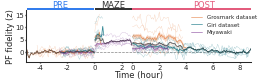

In [276]:
import matplotlib.ticker as ticker

def remove_trailing_zeros(x, pos):
    formatted_label = f"{int(x):d}" if x == int(x) else f"{x:.1f}"
    return formatted_label

#-----------------------------------------------------------------------------------------------------------------------------------------------------------------
# Set up figure colors and style

sns.set_style('whitegrid') 
sns.set_context('paper')

custom_params = {
    "axes.spines.top": False,
    "axes.spines.right": False
    }

sns.set_theme(style="ticks", rc=custom_params)

plt.rcParams.update({
    'font.size':6,
    'axes.linewidth':0.75,
    'pdf.fonttype':42,
    'ps.fonttype':42,
    'axes.labelsize':6,
    'axes.titlesize':6,
    'xtick.labelsize':5,
    'ytick.labelsize':5,
    'legend.fontsize':6,
    'legend.title_fontsize':6,
    'legend.frameon': False,
    'legend.markerscale':2,
    'xtick.major.size':2,
    'ytick.major.size':2
})


epoch_colors = [
    '#005CE9', # PRE
    'black', # MAZE
    '#DD335D', # POST
    ] 

dataset_specific_colors = ["#E58044", "#046C7C", "#85459B"] # , 

#-------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Generate the figure


plotheight = 60
plotwidth = 190
font_size = 5

fig = plt.figure()
fig.set_size_inches([plotwidth/72, plotheight/72])
gs = GridSpec(nrows=2, ncols=1, height_ratios=[0.03, 1], figure=fig, hspace=0.0, wspace=2)



#--------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Plot the LT fidelity across time
ax1 = fig.add_subplot(gs[1])

ax1.axhline(y = 0, linewidth = 0.5, linestyle = '--', color = (.2,.2,.2), alpha = 0.6)


for epoch_index, epoch in enumerate(epoch_names):

    win_centers = moving_time_window_centers_aligned[3][epoch]
    
    for session_idx in range(number_of_sessions):
        session_number = included_session_IDX[session_idx]
        if session_number in range(5):
            color = dataset_specific_colors[0]
        elif session_number in range(6,11):
            color = dataset_specific_colors[1]
        else:
            color = dataset_specific_colors[2]

        ax1.plot(win_centers, moving_window_LT_fidelities_time_windows_aligned[epoch][session_idx], color = color, linewidth = 0.25, alpha = 0.4)

    
    pooled_data = np.concatenate(moving_window_LT_fidelities_time_windows_aligned[epoch], axis = 0).reshape(-1, max_num_windows_across_sessions[3][epoch])



    ## Only Grosmark dataset sessions
    session_indexes = np.arange(5)
 
    curr_mean = np.nanmean(pooled_data[session_indexes], axis = 0)
    curr_error = np.nanstd(pooled_data[session_indexes], axis = 0)/session_indexes.shape[0]
    
    label = 'Grosmark dataset' if epoch_index ==0 else ''
    ax1.plot(win_centers, curr_mean, color = dataset_specific_colors[0], linewidth = 0.5, alpha = 0.8, label = label)
    ax1.fill_between(win_centers, curr_mean-curr_error, curr_mean+curr_error, color = dataset_specific_colors[0], alpha = 0.3, linewidth = 0)



    ## Only Giri dataset sessions
    session_indexes = np.arange(6,11)

    curr_mean = np.nanmean(pooled_data[session_indexes], axis = 0)
    curr_error = np.nanstd(pooled_data[session_indexes], axis = 0)/session_indexes.shape[0]

    label = 'Giri dataset' if epoch_index ==0 else ''
    ax1.plot(win_centers, curr_mean, color = dataset_specific_colors[1], linewidth = 0.5, alpha = 0.8, label = label)
    ax1.fill_between(win_centers, curr_mean-curr_error, curr_mean+curr_error, color = dataset_specific_colors[1], alpha = 0.3, linewidth = 0)



    ## Only Miyawaki dataset session
    session_indexes = np.arange(11,15)
    session_indexes = np.append(session_indexes, 5)

    curr_mean = np.nanmean(pooled_data[session_indexes], axis = 0)
    curr_error = np.nanstd(pooled_data[session_indexes], axis = 0)/session_indexes.shape[0]

    label = 'Miyawaki' if epoch_index ==0 else ''
    ax1.plot(win_centers, curr_mean, color = dataset_specific_colors[2], linewidth = 0.5, alpha = 0.8, label = label)
    ax1.fill_between(win_centers, curr_mean-curr_error, curr_mean+curr_error, color = dataset_specific_colors[2], alpha = 0.3, linewidth = 0)


    ## all sessions
    curr_mean = np.nanmean(pooled_data, axis = 0)
    curr_error = np.nanstd(pooled_data, axis = 0)/number_of_sessions

    ax1.plot(win_centers, curr_mean, color = (.2,.2,.2), linewidth = 0.5, alpha = 0.8)
    ax1.fill_between(win_centers, curr_mean-curr_error, curr_mean+curr_error, color = (.2,.2,.2), alpha = 0.3, linewidth = 0)

ax1.legend(fontsize = 4, loc='upper right',bbox_to_anchor=(1.05, 1))

old_xlim = ax1.get_xlim()
ax1.set_xlim([0, old_xlim[1]-2.8])

x_axis_mapping = [
    [moving_time_window_centers_aligned[3]['PRE'][-1]-4, -4],
    [moving_time_window_centers_aligned[3]['PRE'][-1]-2, -2],
    [moving_time_window_centers_aligned[3]['PRE'][-1], 0],
    [moving_time_window_centers_aligned[3]['MAZE'][0]+2, 2],
    [moving_time_window_centers_aligned[3]['POST'][0], 0],
    [moving_time_window_centers_aligned[3]['POST'][0]+2, 2],
    [moving_time_window_centers_aligned[3]['POST'][0]+4, 4],
    [moving_time_window_centers_aligned[3]['POST'][0]+6, 6],
    [moving_time_window_centers_aligned[3]['POST'][0]+8, 8],
    ]
x_axis_mapping = np.array(x_axis_mapping)

ax1.set_xticks(np.double(x_axis_mapping[:, 0]), x_axis_mapping[:, 1].astype(int))
ax1.set_yticks([0, 5, 10, 15])
# ax1.grid(axis='y', color=(.8,.8,.8), linewidth=0.5)


ax1.set_xlabel('Time (hour)', labelpad = 0)
ax1.set_ylabel('PF fidelity (z)', fontsize = 6, labelpad = 0)


ax1.tick_params(axis='both', which='major', length=1, pad=1, width=1)



#------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Epoch time span indicator bars

ax0 = fig.add_subplot(gs[0], sharex = ax1)

for epoch_index, epoch in enumerate(epoch_names):

    win_centers = moving_time_window_centers_aligned[3][epoch]
    ax0.axvspan(win_centers[0], win_centers[-1], alpha=0.8, color=epoch_colors[epoch_index], linewidth= 0)
    ax0.text(np.mean(win_centers), 1.5, epoch, fontsize=6, ha='center', color=epoch_colors[epoch_index], alpha=0.8)
ax0.axis('off')




plt.subplots_adjust(left=0.1, right= 0.95, bottom=0.25, top=0.90)


filename = 'PF fidelity_over_time.pdf'
file_path = os.path.join(data_dir, filename)
# plt.savefig(file_path, dpi=300)

plt.show()


### Plot the moving-window learned tunings for an example session

#### The following sections are mainly for figure 5, where moving window learned tuning is calculated for the whole POST period and compared against reMAZE place field


In [ ]:


sample_session_index = 8



data_dir = r'/home/kouroshmaboudi/Documents/Learned_tuning_Python/Datasets'
sessions = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

session_name = sessions[sample_session_index]

session_dataset_path = os.path.join(data_dir, session_name)

filename = f'{session_name}.learned_tunings_vs_time_all_offline.npy'
file_path = os.path.join(session_dataset_path, filename)
    
learned_tunings_vs_time_all_offline = np.load(file_path, allow_pickle = True).item()




# Rat U
# units_to_plot = np.array([25, 87, 23, 40]) # Rat U - all units that I found
# units_to_plot = np.array([25, 87, 40]) # Rat U - the unit that will be included in the main figure
# units_to_plot = np.array([130, 49, 52, 37, 110, 0, 152, 14, 99]) # Rat U from figure 5e-bottom
# units_to_plot = np.array([13, 164, 127, 31,149, 16, 136, 32,61, 137, 115, 67, 19]) # Rat U from figure5e_bottom
units_to_plot = np.arange(80, 100)

# Rat V-Day1 Linear
# units_to_plot = np.array([18]) # Rat V-Day 1 Linear 
# units_to_plot = np.array([11, 31, 35]) # Rat V-Day1 Linear from figure 5e


# Rat V-Day 3 Semi-circular
# units_to_plot = np.array([37, 48, 8, 57]) # Rat V-Day 3 Semi-circular - all units that I found
# units_to_plot = np.array([57]) # the unit that will be included in the main figure
# units_to_plot = np.array([63, 66]) # Rat V-Day 3 gradual drift

# ---------------------------------------------------------------------------------------------------------------------------------------------------------------
# Define functions

def max_normalize_columns(matrix):
    """
    Takes a matrix as input and returns a new matrix where each column sums up to one (a probability distribution)
    """
    # calculate the sum of each column
    col_max = np.max(matrix, axis=0)
    
    # divide each element in a column by its sum
    normalized_matrix = matrix / col_max[np.newaxis, :]
    
    return normalized_matrix


#-----------------------------------------------------------------------------------------------------------------------------------------------------------------
# Set up figure colors and style

sns.set_style('whitegrid') # Set style and context
sns.set_context('paper')

custom_params = {"axes.spines.top": False, "axes.spines.right": False}
sns.set_theme(style="ticks", rc=custom_params)

plt.rcParams.update({
    'font.size':5,
    'axes.linewidth':1,
    'pdf.fonttype':42,
    'ps.fonttype':42,
    'axes.labelsize':6,
    'axes.titlesize':6,
    'xtick.labelsize':5,
    'ytick.labelsize':5,
    'legend.fontsize':5,
    'legend.title_fontsize':6,
    'legend.frameon': False,
    'legend.markerscale':2,
    'xtick.major.size':2,
    'ytick.major.size':2
})

epoch_colors = [
    '#005CE9', # PRE
    'black', # MAZE
    '#DD335D', # POST
    '#DC9A5D', # late POST
    ] 


# tunings_to_plot_names = ['maze_theta', 'MAZE', 'spatial_tunings_maze', 'POST', 'spatial_tunings_remaze']
# tunings_to_plot_names = ['spatial_tunings_maze', 'PRE', 'POST', 'latePOST', 'spatial_tunings_remaze']
tunings_to_plot_names = ['spatial_tunings_maze']

# colors for the LTs and PFs
tuning_colors = dict()
tuning_colors['spatial_tunings_maze'] = [0.1490, 0.1490,  0.1490]
tuning_colors['PRE'] = '#005CE9'
# tuning_colors['maze_theta'] = [0.2039, 0.3843, 0.1882]
# tuning_colors['MAZE'] = [0.0627, 0.5451, 0.2667]
tuning_colors['POST'] = '#DC335D'
tuning_colors['latePOST'] = '#DC9A5D'
tuning_colors['spatial_tunings_remaze'] = [0.1490, 0.1490,  0.1490]

# offsets for plotting the tuning curves next to each other  
tuning_x_offsets = dict()
tuning_x_offsets['spatial_tunings_maze'] = 0
tuning_x_offsets['PRE'] = 1
# tuning_x_offsets['maze_theta']
# tuning_x_offsets['MAZE']
tuning_x_offsets['POST'] = 2
tuning_x_offsets['latePOST'] = 3
tuning_x_offsets['spatial_tunings_remaze'] = 4



#-------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Generate the figure

# Create figure and subplots
# plotheight = 1.08
plotheight = 15
plotwidth = 5
font_size = 6


fig = plt.figure()
fig.set_size_inches([plotwidth, plotheight])
gs = GridSpec(nrows=2+units_to_plot.shape[0], ncols=2, figure=fig, width_ratios=[1, 0.2], height_ratios = [.1, .5]+[1]*units_to_plot.shape[0], hspace=0.3, wspace=0.02)


epochs_time_span_in_hours = epochs[sample_session_index]/3600

t_start = learned_tunings_vs_time_all_offline['PRE']['win_centers'][0]/3600
t_end   = learned_tunings_vs_time_all_offline['POST']['win_centers'][-1]/3600


#------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Brain state indicator bars

ax1 = fig.add_subplot(gs[1, 0])

ax1.imshow(time_bin_brain_state_2D_array[sample_session_index], extent = [time_bins_centers[sample_session_index][0]/3600, time_bins_centers[sample_session_index][-1]/3600, 0, 4], interpolation='nearest', cmap='binary', origin='lower')
ax1.set_aspect("auto")

# ax1.axis('off')
ax1.set_xlim([0, t_end])
ax1.tick_params(axis='both', which='major', labelsize=5, width=1)
ax1.set_yticks(np.array([1,2,3,4])-0.5,  brainStates_names, fontsize= 4)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.set_xticks([])
ax1.tick_params(axis='both', which='both', length=0, pad=2)


#------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Epoch time span indicator bars

ax0 = fig.add_subplot(gs[0, 0], sharex = ax1)

epochs_time_span_in_hours_including_latePOST = np.concatenate((epochs_time_span_in_hours, np.zeros((1, 2))), axis=0 )
epochs_time_span_in_hours_including_latePOST[2,1] = epochs_time_span_in_hours[2,0] + 4
epochs_time_span_in_hours_including_latePOST[3,0] = epochs_time_span_in_hours[2,0] + 4
epochs_time_span_in_hours_including_latePOST[3,1] = epochs_time_span_in_hours[2,1]

epochs_plus_latePOST = ['PRE', 'MAZE', 'POST', 'late POST']

for epoch_index, epoch in enumerate(epochs_plus_latePOST):
    start,end = epochs_time_span_in_hours_including_latePOST[epoch_index]
    ax0.axvspan(start, end-0.02, alpha=0.8, color=epoch_colors[epoch_index], linewidth= 0)
    ax0.text(np.mean(epochs_time_span_in_hours_including_latePOST[epoch_index]), 1.3, epoch, fontsize=6, ha='center', color=epoch_colors[epoch_index], alpha=0.8)
ax0.axis('off')
ax0.set_xlim([0, t_end])



#---------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Moving-window LTs 

ax_start_index = 2
for unit_index, unit in enumerate(units_to_plot):
    
    #------------------------------------------------------------------------------
    # Left panels: Learned tunings in 15 minutes time windows for the current unit

    ax2 = fig.add_subplot(gs[unit_index + ax_start_index, 0])

    for j, epoch in enumerate(epoch_names):

        LTs = learned_tunings_vs_time_all_offline[epoch]['learned_tunings_all_offline_across_time'][unit, :, :]
        LTs = max_normalize_columns(LTs)
        LTs[np.isnan(LTs)] = 0

        if (unit_index == 0) & (j==0):
            num_pos_bins = LTs.shape[0]
        
        ax2.imshow(LTs, extent = [epochs_time_span_in_hours[j, 0], epochs_time_span_in_hours[j, 1], 0, num_pos_bins], interpolation='nearest', origin = 'lower', cmap='inferno', label=epoch) 


    ax2.set_xlim([0, t_end])
    ax2.set_title(f"unit {unit}", loc = 'left', fontsize= 5, y=0.75)
    ax2.set_aspect("auto")
    
    ax2.axvline(x = epochs_time_span_in_hours[1, 0], color='white', linestyle='--', linewidth=0.5)
    ax2.axvline(x = epochs_time_span_in_hours[1, 1], color='white', linestyle='--', linewidth=0.5)

    ax2.set_xticks(np.arange(0, t_end, 2))
    if unit_index == (units_to_plot.shape[0]-1):
        ax2.set_xlabel('Time(h)', labelpad=0)
    else:
        ax2.set_xticklabels('')
    
    ax2.set_yticks([0, num_pos_bins], [0, 1])
    ax2.set_ylabel('Position', fontsize=5, labelpad=0)
    ax2.tick_params(axis='both', which='major', labelsize=5, length=2, width=1, pad=1)

    
    # #------------------------------------------------------------------------------------
    # # Right Panels: MAZE theta and ripple learned tunings, MAZE PF, POST LT and reMAZE PF

    ax3 = fig.add_subplot(gs[unit_index+ax_start_index, 1])

    for tuning_index, tuning_name in  enumerate(tunings_to_plot_names):
        if tuning_name in learned_tunings:
            current_tuning = learned_tunings[tuning_name][unit]          
        else: # place fields, maze and remaze
            current_tuning = spatial_tunings_maze[sample_session_index][unit]
            # current_tuning = locals()[tuning_name][unit]

        if np.all(current_tuning == 0):
            ax3.plot(tuning_x_offsets[tuning_name]+current_tuning, np.arange(num_pos_bins), color = tuning_colors[tuning_name], linewidth=0.5, linestyle='--')
        else:    
            current_tuning = current_tuning/np.max(current_tuning)
            current_tuning = current_tuning - np.nanmin(current_tuning)
            ax3.plot(tuning_x_offsets[tuning_name]+current_tuning, np.arange(num_pos_bins), color = tuning_colors[tuning_name], linewidth=0.5, alpha= 0.9)
            
            x_left = tuning_x_offsets[tuning_name]
            x_right = current_tuning + tuning_x_offsets[tuning_name]
            
            ax3.fill_betweenx(np.arange(num_pos_bins), x_left, x_right, alpha=0.4, color = tuning_colors[tuning_name], linewidth=0)

    ax3.set_ylim([0, num_pos_bins])
    ax3.set_yticks([0, num_pos_bins], [])
    
    ax3.set_xlim([-0.1, 6])

    if unit_index == 0:
        ax3.set_xticks(np.arange(0,5))
        # ax3.set_xticklabels(['MAZE theta LT', 'MAZE ripple LT', 'MAZE PF', 'POST LT (early)', 'reMAZE PF'], rotation = 45)
        
        ax3.xaxis.tick_top()
        ax3.xaxis.set_label_position('top')
        ax3.set_xticklabels(['MAZE PF', 'PRE LT', 'POST LT', 'late POST LT', 'reMAZE PF'], rotation = 45, ha = 'left')
        ax3.spines['left'].set_visible(False)
        ax3.spines['bottom'].set_visible(False)
        
        cl = list(tuning_colors.values())
        for label_index, label in enumerate(ax3.get_xticklabels()):
            label.set_color(cl[label_index])

    else:
        ax3.axis('off')
        ax3.set_xticklabels('')

    ax3.tick_params(axis='both', which='both', length=0, pad=0)

    



# Adjust the subplots

plt.subplots_adjust(left=0.2, right= 0.85, bottom=0.20, top=0.9, hspace=0.1)



plt.subplots_adjust(hspace=0.5)
plt.show()


filename = f'{session_name}.test.pdf'
file_path = os.path.join(session_dataset_path, filename)
plt.savefig(file_path, dpi=300)


### NREM- or QW-exclusive moving-window learned tunings

In [ ]:

# ---------------------------------------------------------------------------------------------------------------------------------------------------------------
# Define functions

def max_normalize_columns(matrix):
    """
    Takes a matrix as input and returns a new matrix where each column sums up to one (a probability distribution)
    """
    # calculate the sum of each column
    col_max = np.max(matrix, axis=0)
    
    # divide each element in a column by its sum
    normalized_matrix = matrix / col_max[np.newaxis, :]
    
    return normalized_matrix


#-----------------------------------------------------------------------------------------------------------------------------------------------------------------
# Set up figure epoch_colors and style

sns.set_style('whitegrid') # Set style and context
sns.set_context('paper')

custom_params = {"axes.spines.top": False, "axes.spines.right": False}
sns.set_theme(style="ticks", rc=custom_params)

plt.rcParams.update({
    'font.size':5,
    'axes.linewidth':1,
    'pdf.fonttype':42,
    'ps.fonttype':42,
    'axes.labelsize':6,
    'axes.titlesize':6,
    'xtick.labelsize':5,
    'ytick.labelsize':5,
    'legend.fontsize':5,
    'legend.title_fontsize':6,
    'legend.frameon': False,
    'legend.markerscale':2,
    'xtick.major.size':2,
    'ytick.major.size':2
})

epoch_colors = [
    '#005CE9', # PRE
    'black', # MAZE
    '#DD335D', # POST
    ''
    ] 


#-------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Generate the figure

# Create figure and subplots
plotheight = 5
plotwidth = 5
font_size = 6


fig = plt.figure()
fig.set_size_inches([plotwidth, plotheight])
gs = GridSpec(nrows=units_to_plot.shape[0]+2, ncols=1, figure=fig, width_ratios=[1], height_ratios = [.1, .3]+[1]*units_to_plot.shape[0], hspace=0.3, wspace=0.2)

#---------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Moving-window LTs 


epochs_time_span_in_hours = epochs/3600


t_start = learned_tunings_vs_time_NREM_vs_QW['PRE']['win_centers'][0]/3600
t_end   = learned_tunings_vs_time_NREM_vs_QW['POST']['win_centers'][-1]/3600


ax_start_index = 2
for unit_index, unit in enumerate(units_to_plot):

    ax2 = fig.add_subplot(gs[unit_index + ax_start_index])

    for j, epoch in enumerate(epoch_names):

        NREM_LT = learned_tunings_vs_time_NREM_vs_QW[epoch]['learned_tunings_NREM_across_time'][unit, :, :]
        NREM_LT = max_normalize_columns(NREM_LT) # divide each column by its maximum value

        QW_LT = learned_tunings_vs_time_NREM_vs_QW[epoch]['learned_tunings_QW_across_time'][unit, :, :]
        QW_LT = max_normalize_columns(QW_LT)

        LT = np.concatenate([QW_LT, NREM_LT], axis=0) # concatenate the NREM and QW learned tunings along position dimension in order to plot them together

        ax2.imshow(LT, extent = [epochs_time_span_in_hours[j, 0], epochs_time_span_in_hours[j, 1], 0, num_pos_bins*2], interpolation='nearest', origin = 'lower', cmap='inferno', label=epoch) 

    ax2.set_xlim([0, t_end])
    ax2.set_title(f"unit {unit}", loc = 'left', fontsize= 5, y=0.92)
    ax2.set_aspect("auto")
    ax2.tick_params(axis='both', which='major', labelsize=5)
    ax2.axhline(y = num_pos_bins, color='white', linestyle='--', linewidth=0.5)
    ax2.axvline(x = epochs_time_span_in_hours[1, 0], color='gray', linestyle='-', linewidth=0.5)
    ax2.axvline(x = epochs_time_span_in_hours[1, 1], color='gray', linestyle='-', linewidth=0.5)

    if unit_index == 0:
        ax2.text(-1.5, 0.4*num_pos_bins, 'QW:', fontsize=6, ha = 'left', color='black', alpha = 0.8)
        ax2.text(-1.5, 1.4*num_pos_bins, 'NREM:', fontsize=6, ha = 'left', color='black', alpha = 0.8)

    ax2.set_xticks(np.arange(0, t_end, 2))
    if unit_index == (units_to_plot.shape[0]-1):
        ax2.set_xlabel('Time(h)')
    else:
        ax2.set_xticklabels('')
    
    ax2.set_yticks([0, num_pos_bins, num_pos_bins*2], [0, '0\n1', 1])
    ax2.set_ylabel('position', fontsize=6)

#------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Brain state indicator bars

ax1 = fig.add_subplot(gs[1])

ax1.imshow(time_bin_brain_state_2D_array, extent = [time_bins_centers[0]/3600, time_bins_centers[-1]/3600, 0, 4], interpolation='nearest', cmap='binary', origin='lower')
ax1.set_aspect("auto")

# ax1.axis('off')
ax1.set_xlim([0, t_end])
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_yticks(np.array([1,2,3,4])-0.5,  brainStates_names, fontsize= 4)
ax1.spines['bottom'].set_visible(False)
ax1.set_xticks([])


# # plot brain states based on Bapun's calculations
# for bout_idx in range(bout_labels_Bapun.shape[0]):
#     axes[2].barh(y = bout_labels_Bapun[bout_idx], left=bouts_start_bapun[bout_idx], width = bouts_end_bapun[bout_idx]-bouts_start_bapun[bout_idx], height=1, color=epoch_colors[bout_labels_Bapun[bout_idx]-1]) #
# # axes[1].axis('off')
# axes[2].set_yticks([1,2,3,4],  brainStates_names)
# axes[2].tick_params(axis='both', which='major', labelsize=5)

#------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Brain state indicator bars

ax1 = fig.add_subplot(gs[1])

ax1.imshow(time_bin_brain_state_2D_array, extent = [time_bins_centers[0]/3600, time_bins_centers[-1]/3600, 0, 4], interpolation='nearest', cmap='binary', origin='lower')
ax1.set_aspect("auto")

# ax1.axis('off')
ax1.set_xlim([0, t_end])
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_yticks(np.array([1,2,3,4])-0.5,  brainStates_names, fontsize= 4)
ax1.spines['bottom'].set_visible(False)
ax1.set_xticks([])


# # plot brain states based on Bapun's calculations
# for bout_idx in range(bout_labels_Bapun.shape[0]):
#     axes[2].barh(y = bout_labels_Bapun[bout_idx], left=bouts_start_bapun[bout_idx], width = bouts_end_bapun[bout_idx]-bouts_start_bapun[bout_idx], height=1, color=epoch_colors[bout_labels_Bapun[bout_idx]-1]) #
# # axes[1].axis('off')
# axes[2].set_yticks([1,2,3,4],  brainStates_names)
# axes[2].tick_params(axis='both', which='major', labelsize=5)



#------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Epoch time span indicator bars

ax0 = fig.add_subplot(gs[0], sharex = ax1)

for epoch_index, epoch in enumerate(epoch_names):
    start,end = epochs_time_span_in_hours[epoch_index]
    ax0.axvspan(start, end-0.05, alpha=0.8, color=epoch_colors[epoch_index], )
    ax0.text(np.mean(epochs_time_span_in_hours[epoch_index]), 1.3, epoch, fontsize=8, ha='center', color=epoch_colors[epoch_index], alpha=0.8)
ax0.axis('off')


#------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Epoch time span indicator bars

ax0 = fig.add_subplot(gs[0], sharex = ax1)

for epoch_index, epoch in enumerate(epoch_names):
    start,end = epochs_time_span_in_hours[epoch_index]
    ax0.axvspan(start, end-0.05, alpha=0.8, color=epoch_colors[epoch_index], )
    ax0.text(np.mean(epochs_time_span_in_hours[epoch_index]), 1.3, epoch, fontsize=8, ha='center', color=epoch_colors[epoch_index], alpha=0.8)
ax0.axis('off')



# Adjust the subplots

plt.subplots_adjust(left=0.2, right= 0.85, bottom=0.20, top=0.9, hspace=0.1)


# plt.tight_layout()

plt.show()

filename = f'{session_name}.QW_NREM_learned_tuning_vs_time_2.svg'
file_path = os.path.join(session_dataset_path, filename)
plt.savefig(file_path, dpi=300)